# Предсказание стоимости подержанного автомобиля
## Описание задачи
Многие знают про маркетплейсы где продаются б/у вещи, на которых есть возможность недорого купить качественную и полезную вещь. Но всегда волнует вопрос - кто и как устанавливает цену, и какие его характеристики больше всего влияют на итоговую стоимость продажи?! Вопрос становиться особо актуальным, если речь идет про дорогие товары, например про автомобили!

**Целью проекта** будет разработанная модель предсказания стоимости автомобиля на вторичном рынке.

## Предоставленные данные 
train.csv - информация о характеристиках автомобилей (~440000), которые будут использоваться в качестве обучающих данных.

test.csv - информация о характеристиках автомобилей (~110000), которые будут использоваться в качестве тестовых данных.

**Задача** - предсказать значение 'sellingprice' для каждого автомобиля из датасета test.csv.

sample_submission.csv - пример файла предсказаний в правильном формате.

vin - идентификатор автомобиля в тестовом наборе.

sellingprice - Целевой признак. Для каждого автомобиля предскажите числовое значение стоимости продажи.

**Описание полей данных** 

Date: Год выпуска автомобиля.

Make: Марка автомобиля.

Model: Модель автомобиля определенной марки.

Trim: Модификации автомобиля.

Body: Тип кузова транспортного средства относится к форме и модели конкретной марки автомобиля.

Transmission: Тип коробки передач.

VIN: Идентификационный номер транспортного средства.

State: Штат, в котором автомобиль выставлен на аукцион.

Condition: Состояние автомобилей на момент аукциона.

Odometer: Пробег - расстояние, пройденное автомобилем с момента выпуска.

Color: Цвет кузова автомобиля.

Interior: Цвет салона автомобиля.

Seller: Продавец автомобиля, автосалоны.

sellingprice: цена, по которой автомобиль был продан на аукционе.

saledate: Дата продажи автомобиля.

**Импортируем необходимые нам библиотеки и функции**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from catboost import CatBoostRegressor, Pool

In [2]:
RANDOM_STATE = 12345

## Шаг 1: Загрузка и ознакомление с данными

Напишем функцию для получения информации о датасете (вывод первых пяти срок, общей информации методом info(), описания информации в столбцах методом discribe(), построение гистограмм для визуализации распределения данных в столбцах), наличия явных дубликатов, построения матрицы корреляции с визуализацией в seaborn.

In [3]:
def get_info(data):
    display('Вывод первых 5-ти строк датасета', data.head())
    display(data.info())
    print('Количество явных дубликатов:', data.duplicated().sum())
    display(data.describe())
    data.hist(figsize=(8, 8));
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.heatmap(data.corr(), annot = True, fmt='.2g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', 
                annot_kws={"fontsize":7})

Cчитываем данные из файлов train и test, сохраняем их в переменные df_train, df_test соответсвенно, получаем общую информацию о датафреймах с помощью функции get_info()

Данные по обучающей выборке


'Вывод первых 5-ти строк датасета'

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


None

Количество явных дубликатов: 0


,year,condition,odometer,sellingprice
count,440236.000000,430831.000000,440167.000000,440236.000000
mean,2010.040101,3.425077,68344.421604,13592.209588
std,3.977945,0.949973,53542.203908,9751.479098
min,1982.000000,1.000000,1.000000,1.000000
25%,2007.000000,2.700000,28258.000000,6900.000000
50%,2012.000000,3.600000,52098.000000,12100.000000
75%,2013.000000,4.200000,99272.000000,18200.000000
max,2015.000000,5.000000,999999.000000,230000.000000


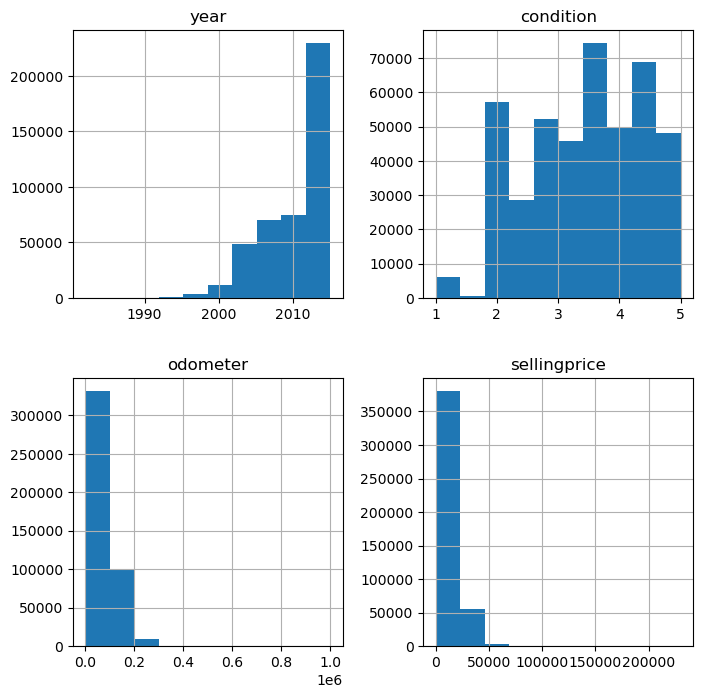

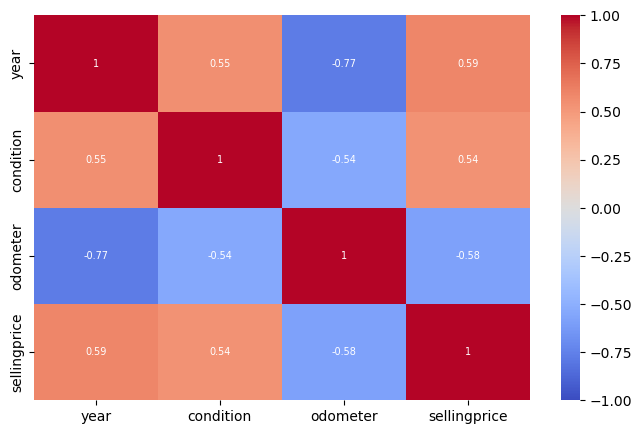

In [4]:
df_train = pd.read_csv(r"C:\Users\bniko\project_car_sellingprice\train.csv")
print('Данные по обучающей выборке')
get_info(df_train)

Данные по тестовой выборке


'Вывод первых 5-ти строк датасета'

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,Fri Mar 06 2015 02:00:00 GMT-0800 (PST)
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,Wed Jun 03 2015 03:30:00 GMT-0700 (PDT)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110058 non-null  int64  
 1   make          107997 non-null  object 
 2   model         107979 non-null  object 
 3   trim          107944 non-null  object 
 4   body          107464 non-null  object 
 5   transmission  97047 non-null   object 
 6   vin           110058 non-null  object 
 7   state         110058 non-null  object 
 8   condition     107679 non-null  float64
 9   odometer      110039 non-null  float64
 10  color         109900 non-null  object 
 11  interior      109900 non-null  object 
 12  seller        110058 non-null  object 
 13  saledate      110058 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 11.8+ MB


None

Количество явных дубликатов: 0


,year,condition,odometer
count,110058.000000,107679.000000,110039.000000
mean,2010.060005,3.423222,68074.331601
std,3.960190,0.951301,53520.988173
min,1982.000000,1.000000,1.000000
25%,2007.000000,2.700000,28313.500000
50%,2012.000000,3.600000,51922.000000
75%,2013.000000,4.200000,98852.500000
max,2015.000000,5.000000,999999.000000


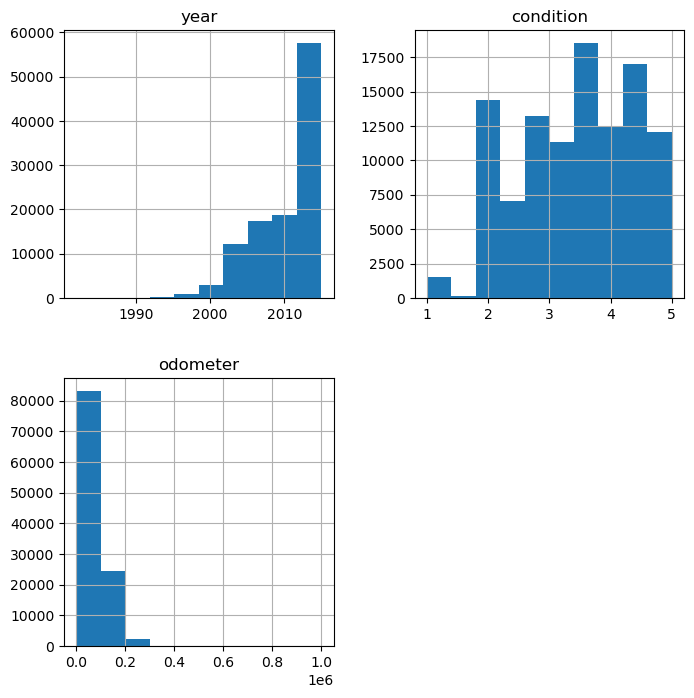

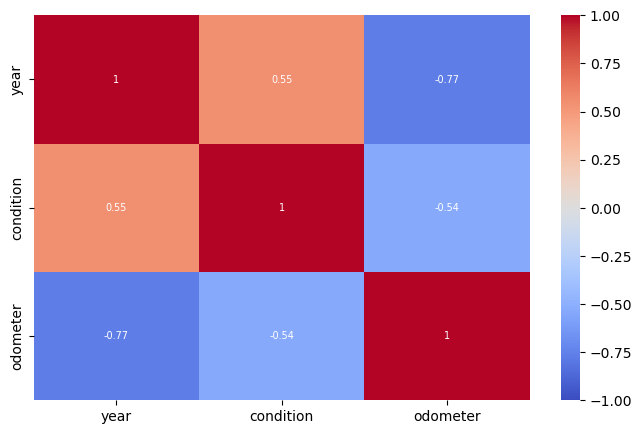

In [5]:
df_test = pd.read_csv(r"C:\Users\bniko\project_car_sellingprice\test.csv")
print('Данные по тестовой выборке')
get_info(df_test)

Скачиваем данные их файла sample_submission, сохраняем в переменной submission и смотрим общую информацию о датасете.

In [6]:
submission = pd.read_csv(r"C:\Users\bniko\project_car_sellingprice\sample_submission.csv")
print(submission.info())
submission.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           110058 non-null  object 
 1   sellingprice  110058 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.7+ MB
None


,vin,sellingprice
0,1g6dp567450124779,13592.209588
1,1gtw7fca7e1902207,13592.209588
2,jn8az1mw6dw303497,13592.209588
3,2g1wf5e34d1160703,13592.209588
4,1n6aa0ec3dn301209,13592.209588


#### Открыв файл и ознакомившись с общей информацией по датафреймам можно сделать следующие выводы: 
- в таблице df_train 440236 строк 15 столбцов, в таблице df_test 110058 строк 14 столбцов. В датафрейме df_tes отсутсвует столбец sellingprice, остальные столбцы совпадают;
- во всех столбцах df_train и df_test кроме year, vin, state, seller, saledate и столбца sellingprice в df_train есть пропуски, исследуем их далее; 
- явных дубликатов нет;
- необходимо перевести данные столбца saledate в формат datetime;
- в целом распределение данных выглядит логичным, более детальный анализ проведем далее;
- в датафрейме df_train прослеживается зависимость целевого признака sellingprice от призников year, condition и odometer (коэффициент пирсона 0.5 - 0.6). Так же признаки year, condition и odometer коллинеарные, особенно year и odometr. Аналогичная ситуация с признакми в df_test. Это нужно учесть при обучении моделей;  
- надо также проверить данные на наличие неявных дубликатов в категориальных переменных.

## Шаг 2: Предобработка данных

### 2.1 Изменим тип данных в столбце saledate в датафреймах df_train и df_test, оставив локальное время покупки

In [7]:
df_train['saledate'] = pd.to_datetime(df_train['saledate'], utc=True)
df_train.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,2015-06-01 19:30:00+00:00
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,2015-02-24 18:00:00+00:00
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,2015-06-09 19:30:00+00:00
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,2015-06-16 20:00:00+00:00
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,2015-02-02 20:00:00+00:00


In [8]:
df_test['saledate'] = pd.to_datetime(df_test['saledate'], utc=True)
df_test.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,2015-01-13 20:30:00+00:00
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,2015-02-26 17:00:00+00:00
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,2015-02-23 17:30:00+00:00
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,2015-03-05 18:00:00+00:00
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,2015-06-02 20:30:00+00:00


### Добавим в оба дата фрейма столбцы с годом, месяцем и днем недели продажи автомобиля. Напишем для этого функцию get_year_month_wday, в которую передаем датафрейм и название столбеца с датой, возвращает три столбца с годом, месяцем и дем продажи автомообиля.

In [9]:
def get_year_month_wday (data, b='date'):
    data['saledate_year'] = data[b].dt.year
    data['saledate_month'] = data[b].dt.month
    data['saledate_week_day'] = data[b].dt.weekday
    return data['saledate_year'], data['saledate_month'], data['saledate_week_day']

In [10]:
df_train['saledate_year'], df_train['saledate_month'], df_train['saledate_week_day'] = get_year_month_wday(df_train, b='saledate')
df_train.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,saledate_year,saledate_month,saledate_week_day
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,2015-06-01 19:30:00+00:00,2015,6,0
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,2015-02-24 18:00:00+00:00,2015,2,1
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,2015-06-09 19:30:00+00:00,2015,6,1
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,2015-06-16 20:00:00+00:00,2015,6,1
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,2015-02-02 20:00:00+00:00,2015,2,0


In [11]:
df_test['saledate_year'], df_test['saledate_month'], df_test['saledate_week_day'] = get_year_month_wday(df_test, b='saledate')
df_test.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate,saledate_year,saledate_month,saledate_week_day
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,2015-01-13 20:30:00+00:00,2015,1,1
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,2015-02-26 17:00:00+00:00,2015,2,3
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,2015-02-23 17:30:00+00:00,2015,2,0
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,2015-03-05 18:00:00+00:00,2015,3,3
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,2015-06-02 20:30:00+00:00,2015,6,1


###  Посмотри уникальные значения в столбце год обоих датафреймов

In [12]:
df_train['saledate_year'].value_counts()

2015    397318
2014     42918
Name: saledate_year, dtype: int64

In [13]:
df_test['saledate_year'].value_counts()

2015    99355
2014    10703
Name: saledate_year, dtype: int64

#### В датафреймах данные о продаже автомобилей в 2014 и 2015 годах. 

###  2.2 Посчитаем количество пропусков в столбцах и далее рассмотрим каждый столбец, где есть пропуски, в отдельности, чтобы понять, как поступать с ними.

In [14]:
df_train.isna().sum()

year                     0
make                  8043
model                 8123
trim                  8337
body                 10393
transmission         51461
vin                      0
state                    0
condition             9405
odometer                69
color                  586
interior               586
seller                   0
sellingprice             0
saledate                 0
saledate_year            0
saledate_month           0
saledate_week_day        0
dtype: int64

In [15]:
df_test.isna().sum()

year                     0
make                  2061
model                 2079
trim                  2114
body                  2594
transmission         13011
vin                      0
state                    0
condition             2379
odometer                19
color                  158
interior               158
seller                   0
saledate                 0
saledate_year            0
saledate_month           0
saledate_week_day        0
dtype: int64

### Посмотри строки с пропусками в столбце make и посмотри уникальные значения в данном столбце

In [16]:
df_train.query('make.isna()')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,saledate_year,saledate_month,saledate_week_day
10,2007,NaN,NaN,NaN,NaN,automatic,5tfbv54157x019560,ca,3.1,102507.0,blue,gray,aaero sweet company,17250,2015-01-28 19:30:00+00:00,2015,1,2
42,2007,NaN,NaN,NaN,NaN,manual,jm1bk34l671745431,md,2.8,92656.0,blue,gray,credit acceptance corp/vrs/southfield,5600,2015-06-15 19:30:00+00:00,2015,6,0
63,2011,NaN,NaN,NaN,NaN,automatic,1fdne1bw5bda64735,ga,5.0,67159.0,white,gray,"vpsi, inc",13200,2015-06-03 20:00:00+00:00,2015,6,2
64,2008,NaN,NaN,NaN,NaN,automatic,1gbdv13wx8d142776,ca,4.1,113582.0,white,gray,wholesale motor sales inc,4100,2015-02-04 20:00:00+00:00,2015,2,2
111,2006,NaN,NaN,NaN,NaN,automatic,3gnda13d36s611801,nv,2.8,129019.0,orange,gray,credit acceptance corp/vrs/southfield,2900,2015-02-04 20:00:00+00:00,2015,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440085,2011,NaN,NaN,NaN,NaN,automatic,1fdne1bw8bdb21610,az,3.5,80594.0,white,gray,mike albert fleet solutions,11100,2015-02-03 19:00:00+00:00,2015,2,1
440114,2011,NaN,NaN,NaN,NaN,automatic,2lnbl8ev9bx757689,nj,3.5,134164.0,—,black,merchants automotive group,11800,2015-03-03 17:30:00+00:00,2015,3,1
440118,2004,NaN,NaN,NaN,NaN,automatic,1gyde637240130408,md,3.5,123123.0,white,beige,credit acceptance corp/vrs/southfield,3400,2015-02-16 17:30:00+00:00,2015,2,0
440122,2007,NaN,NaN,NaN,NaN,automatic,salme15487a251642,ca,2.5,39545.0,black,black,hornburg jaguar,17750,2015-06-16 22:15:00+00:00,2015,6,1


In [17]:
df_train.query('(make.isna() and not(body.isna())) or (make.isna() and not(model.isna())) or (make.isna() and not(trim.isna()))')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,saledate_year,saledate_month,saledate_week_day


#### Посмотрев на пропуске в столбце make увидили, что в строках также отсутсвуют данные по model, trim, body. Причем строк, где make пропущено, а в столбцах model, trim, body информация есть - нет. Почему данные отсутсвуют сказать сложно, скорее всего технический сбой, например при объеденении таблиц. Удалить данные строки считаю неверным, т.к. в датафрейме df_test также есть пропуски в данном столбце, следовательно предсказывать стоимость автомобиля нам надо будет и без данной информации. Восстановить данные можно по vin, где вся эта информация зашифрована, но на данный момент для меня это отдельный проект. Поэтому заменю пропуски в данном столбце на unknown.

In [18]:
df_train.loc[df_train['make'].isna(), 'make'] = 'unknown'
df_train['make'].isna().sum()

0

In [19]:
df_train['make'].unique()

array(['Ford', 'Nissan', 'HUMMER', 'Lincoln', 'pontiac', 'Hyundai',
       'unknown', 'Buick', 'Chevrolet', 'Honda', 'Acura', 'Cadillac',
       'GMC', 'Saab', 'Dodge', 'Mercedes-Benz', 'Toyota', 'Volkswagen',
       'BMW', 'Infiniti', 'Chrysler', 'Kia', 'Jaguar', 'Subaru', 'Jeep',
       'Lexus', 'mercedes', 'Scion', 'FIAT', 'Suzuki', 'Mazda', 'Volvo',
       'Audi', 'MINI', 'Isuzu', 'Mitsubishi', 'smart', 'Pontiac',
       'Porsche', 'subaru', 'ford', 'Land Rover', 'chrysler', 'Saturn',
       'mazda', 'dodge', 'Ram', 'Oldsmobile', 'hyundai', 'Mercury',
       'Bentley', 'toyota', 'lincoln', 'Fisker', 'nissan', 'chevrolet',
       'honda', 'porsche', 'mitsubishi', 'lexus', 'bmw', 'Maserati',
       'acura', 'jeep', 'mercury', 'Tesla', 'landrover', 'vw', 'cadillac',
       'buick', 'gmc truck', 'land rover', 'volkswagen', 'Rolls-Royce',
       'audi', 'Ferrari', 'suzuki', 'Plymouth', 'oldsmobile',
       'Lamborghini', 'gmc', 'Geo', 'ford truck', 'Aston Martin',
       'plymouth', 'Da

#### В названиях марок используется разный регистр, приведем все к нижнему регистру, чтобы исключить дубликаты. Аналогичная ситуация наблюдается в столбцах model, trim, body

In [20]:
column = ['make', 'model', 'trim', 'body']
for col in column:
    df_train[col] = df_train[col].str.lower()
df_train.head()    

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,saledate_year,saledate_month,saledate_week_day
0,2011,ford,edge,sel,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,2015-06-01 19:30:00+00:00,2015,6,0
1,2014,ford,fusion,se,sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,2015-02-24 18:00:00+00:00,2015,2,1
2,2012,nissan,sentra,2.0 sl,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,2015-06-09 19:30:00+00:00,2015,6,1
3,2003,hummer,h2,base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,2015-06-16 20:00:00+00:00,2015,6,1
4,2007,ford,fusion,sel,sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,2015-02-02 20:00:00+00:00,2015,2,0


In [21]:
df_train['make'].unique()

array(['ford', 'nissan', 'hummer', 'lincoln', 'pontiac', 'hyundai',
       'unknown', 'buick', 'chevrolet', 'honda', 'acura', 'cadillac',
       'gmc', 'saab', 'dodge', 'mercedes-benz', 'toyota', 'volkswagen',
       'bmw', 'infiniti', 'chrysler', 'kia', 'jaguar', 'subaru', 'jeep',
       'lexus', 'mercedes', 'scion', 'fiat', 'suzuki', 'mazda', 'volvo',
       'audi', 'mini', 'isuzu', 'mitsubishi', 'smart', 'porsche',
       'land rover', 'saturn', 'ram', 'oldsmobile', 'mercury', 'bentley',
       'fisker', 'maserati', 'tesla', 'landrover', 'vw', 'gmc truck',
       'rolls-royce', 'ferrari', 'plymouth', 'lamborghini', 'geo',
       'ford truck', 'aston martin', 'daewoo', 'mercedes-b', 'dodge tk',
       'mazda tk', 'dot', 'airstream'], dtype=object)

In [22]:
dictionary = {'vw':'volkswagen', 'land rower': 'landrover', 'mercedes-benz': 'mercedes', 'gmc truck': 'gmc',
             'ford truck': 'ford', 'dodge tk': 'dodge', 'mercedes-b': 'mercedes', 'mazda tk': 'mazda'} 

df_train['make'] = df_train['make'].replace(dictionary, regex=True)
df_train['make'].unique()

array(['ford', 'nissan', 'hummer', 'lincoln', 'pontiac', 'hyundai',
       'unknown', 'buick', 'chevrolet', 'honda', 'acura', 'cadillac',
       'gmc', 'saab', 'dodge', 'mercedes', 'toyota', 'volkswagen', 'bmw',
       'infiniti', 'chrysler', 'kia', 'jaguar', 'subaru', 'jeep', 'lexus',
       'scion', 'fiat', 'suzuki', 'mazda', 'volvo', 'audi', 'mini',
       'isuzu', 'mitsubishi', 'smart', 'porsche', 'land rover', 'saturn',
       'ram', 'oldsmobile', 'mercury', 'bentley', 'fisker', 'maserati',
       'tesla', 'landrover', 'rolls-royce', 'ferrari', 'plymouth',
       'lamborghini', 'geo', 'aston martin', 'daewoo', 'dot', 'airstream'],
      dtype=object)

### Аналогичные действия проводим для датафрейма df_test

In [23]:
df_test.query('make.isna()')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate,saledate_year,saledate_month,saledate_week_day
22,2006,NaN,NaN,NaN,NaN,automatic,3gnda23d06s523147,pa,2.4,143377.0,blue,gray,ryan mtrs of morristown inc,2015-01-22 17:00:00+00:00,2015,1,3
72,2000,NaN,NaN,NaN,NaN,manual,1j4fa59s0yp723644,mo,NaN,76674.0,black,—,effingham auto care & tire inc,2014-12-22 03:00:00+00:00,2014,12,0
220,2003,NaN,NaN,NaN,NaN,automatic,jtjbt20x930014425,tx,4.9,107337.0,silver,gray,fairway ford henderson,2015-02-17 18:00:00+00:00,2015,2,1
237,1998,NaN,NaN,NaN,NaN,automatic,1j4gz78yxwc163618,nv,2.0,243163.0,gray,—,titlemax/las vegas nv32,2015-02-18 19:00:00+00:00,2015,2,2
287,2009,NaN,NaN,NaN,NaN,automatic,1gbhg39c591143468,pa,2.1,179884.0,white,gray,lease plan usa,2015-02-23 17:30:00+00:00,2015,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109622,2007,NaN,NaN,NaN,NaN,automatic,jm1fe173470212203,wa,2.0,133227.0,blue,beige,primus automotive financial services,2015-02-10 20:35:00+00:00,2015,2,1
109665,2010,NaN,NaN,NaN,NaN,automatic,4a32b2ff4ae011675,fl,2.9,69783.0,black,gray,premier partners inc.,2015-01-14 18:30:00+00:00,2015,1,2
109717,1999,NaN,NaN,NaN,NaN,automatic,1gcdl19w1xb115016,pa,3.7,179570.0,white,blue,ari,2015-02-09 17:30:00+00:00,2015,2,0
109948,2006,NaN,NaN,NaN,NaN,automatic,2hjyk16546h509272,md,3.2,107466.0,white,beige,wells fargo dealer services,2015-05-25 19:30:00+00:00,2015,5,0


In [24]:
df_test.query('(make.isna() and not(body.isna())) or (make.isna() and not(model.isna())) or (make.isna() and not(trim.isna()))')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate,saledate_year,saledate_month,saledate_week_day


In [25]:
df_test.loc[df_test['make'].isna(), 'make'] = 'unknown'
df_test['make'].isna().sum()

0

In [26]:
for col in column:
    df_test[col] = df_test[col].str.lower()
df_test.head()    

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate,saledate_year,saledate_month,saledate_week_day
0,2005,cadillac,cts,base,sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,2015-01-13 20:30:00+00:00,2015,1,1
1,2014,gmc,savana cargo,2500,van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,2015-02-26 17:00:00+00:00,2015,2,3
2,2013,nissan,murano,s,suv,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,2015-02-23 17:30:00+00:00,2015,2,0
3,2013,chevrolet,impala,ls fleet,sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,2015-03-05 18:00:00+00:00,2015,3,3
4,2013,nissan,titan,sv,crew cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,2015-06-02 20:30:00+00:00,2015,6,1


In [27]:
df_test['make'].unique()

array(['cadillac', 'gmc', 'nissan', 'chevrolet', 'volkswagen', 'hyundai',
       'ford', 'infiniti', 'subaru', 'kia', 'bmw', 'unknown',
       'mitsubishi', 'dodge', 'oldsmobile', 'volvo', 'pontiac', 'acura',
       'honda', 'toyota', 'audi', 'jeep', 'lincoln', 'chrysler',
       'mercedes-benz', 'ram', 'scion', 'mercury', 'lexus', 'saturn',
       'mazda', 'porsche', 'mini', 'smart', 'buick', 'hummer', 'jaguar',
       'fiat', 'saab', 'suzuki', 'land rover', 'landrover', 'geo',
       'chev truck', 'bentley', 'isuzu', 'aston martin', 'maserati',
       'daewoo', 'vw', 'tesla', 'mercedes', 'ferrari', 'fisker',
       'rolls-royce', 'lotus', 'plymouth', 'hyundai tk', 'ford tk'],
      dtype=object)

In [28]:
dictionary_1 = {'vw':'volkswagen', 'land rower': 'landrover', 'mercedes-benz': 'mercedes', 'hyundai tk': 'hyundai',
             'ford tk': 'ford', 'chev truck': 'chevrolet'} 

df_test['make'] = df_test['make'].replace(dictionary_1, regex=True)
df_test['make'].unique()

array(['cadillac', 'gmc', 'nissan', 'chevrolet', 'volkswagen', 'hyundai',
       'ford', 'infiniti', 'subaru', 'kia', 'bmw', 'unknown',
       'mitsubishi', 'dodge', 'oldsmobile', 'volvo', 'pontiac', 'acura',
       'honda', 'toyota', 'audi', 'jeep', 'lincoln', 'chrysler',
       'mercedes', 'ram', 'scion', 'mercury', 'lexus', 'saturn', 'mazda',
       'porsche', 'mini', 'smart', 'buick', 'hummer', 'jaguar', 'fiat',
       'saab', 'suzuki', 'land rover', 'landrover', 'geo', 'bentley',
       'isuzu', 'aston martin', 'maserati', 'daewoo', 'tesla', 'ferrari',
       'fisker', 'rolls-royce', 'lotus', 'plymouth'], dtype=object)

### Посмотри строки с пропусками в столбце model и посмотрим уникальные значения в данном столбце

In [29]:
df_train['model'].unique()


array(['edge', 'fusion', 'sentra', 'h2', 'mkz', 'g6', 'escape', 'elantra',
       'freestyle', nan, 'lucerne', 'windstar', 'silverado 1500',
       'murano', 'equinox', 'accord', 'civic', 'mdx', 'cts', 'taurus',
       'srx', 'yukon', '9-3', 'explorer', 'f-150', 'charger', 'armada',
       'gl-class', 'avalon', 'tahoe', 'malibu', 'passat', 'camry', 'flex',
       '3 series', 'q50', 'altima', 'mustang', '300', 'sonata',
       'envoy xl', 'rogue', 'accent', 'maxima', 'forte', 'xf', 'outback',
       'grand caravan', 'e-class', 'cherokee', 'impala', 'optima',
       '5 series', 'expedition', 'is 250', 'mks', '200', 'veloster',
       'golf', 'rav4', 'e300dt', 'five hundred', 'g coupe',
       'grand cherokee', 'x-type', 'g convertible', 'tacoma', 'xa',
       'g sedan', 'tl', 'liberty', 'soul', '500l', 'town and country',
       'hhr', 'wrangler', 'reno', 'suburban', 'pt cruiser', 'gx 460',
       'sienna', 'sl-class', 'envoy', 'patriot', 'e-series van', 'versa',
       'aspen', 'm', 'co

#### Проверим есть ли в таблице строки, где make не равно unknown, а название модели пропущено. 


In [30]:
df_train.query('make != "unknown" and model.isna()').head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,saledate_year,saledate_month,saledate_week_day
133,2014,bmw,NaN,750li,sedan,automatic,wbaye8c58eds16086,ca,4.7,14886.0,gray,black,financial services remarketing (lease),93000,2015-05-20 22:30:00+00:00,2015,5,2
14018,2014,bmw,NaN,750li xdrive,sedan,automatic,wbayf8c50ed142661,oh,3.7,19926.0,white,tan,bmw na manheim new jersey,60500,2014-12-30 06:00:00+00:00,2014,12,1
16652,2015,bmw,NaN,650i xdrive,sedan,automatic,wba6b4c59fd761465,nj,5.0,2496.0,gray,black,bmw na manheim new jersey,78500,2015-06-02 00:00:00+00:00,2015,6,1
17508,2015,audi,NaN,2.0 tfsi premium quattro,sedan,automatic,waubfgff6f1002038,ca,5.0,7652.0,white,black,vw credit,25000,2015-06-17 22:30:00+00:00,2015,6,2
21917,2015,bmw,NaN,750i xdrive,sedan,automatic,wbayb6c50fd965768,nj,4.8,5864.0,—,tan,bmw na manheim new jersey,77000,2015-06-02 00:00:00+00:00,2015,6,1


#### Мы видим, что такие значения есть, при этом есть информация по столбцам trim, body. Попррообуем восстановить по этим данным модель, для это делаем сводную таблицу по столбцам 'make', 'trim', 'body'

In [31]:
df_train.query('make != "unknown" and model.isna()').pivot_table(index=['make', 'trim', 'body'], values='model', aggfunc='count')

model
make trim                     body        
audi 2.0 tfsi premium quattro sedan      0
bmw  650i xdrive              sedan      0
     750i                     sedan      0
     750i xdrive              sedan      0
     750li                    sedan      0
     750li xdrive             sedan      0

In [32]:
df_train.query('make == "audi" and trim == "2.0 tfsi premium quattro"')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,saledate_year,saledate_month,saledate_week_day
17508,2015,audi,NaN,2.0 tfsi premium quattro,sedan,automatic,waubfgff6f1002038,ca,5.0,7652.0,white,black,vw credit,25000,2015-06-17 22:30:00+00:00,2015,6,2
183518,2015,audi,NaN,2.0 tfsi premium quattro,sedan,NaN,waubfgff0f1007039,pa,4.9,8109.0,gray,black,manheim imports,26900,2015-05-27 19:30:00+00:00,2015,5,2
230018,2015,audi,NaN,2.0 tfsi premium quattro,sedan,automatic,waubfgff1f1001122,ca,4.6,8996.0,black,beige,vci/auto gallery,27000,2015-02-25 20:30:00+00:00,2015,2,2
239974,2015,audi,NaN,2.0 tfsi premium quattro,sedan,NaN,waubfgffxf1002043,pa,4.1,4299.0,black,black,audi of huntington,28000,2015-05-21 19:00:00+00:00,2015,5,3
286216,2015,audi,NaN,2.0 tfsi premium quattro,sedan,automatic,waubfgff3f1002269,ca,4.8,9070.0,gray,black,vci/auto gallery,27000,2015-02-25 20:30:00+00:00,2015,2,2
326034,2015,audi,NaN,2.0 tfsi premium quattro,sedan,automatic,waubfgff3f1005561,fl,4.7,5767.0,white,black,vw credit,25200,2015-01-20 17:30:00+00:00,2015,1,1
358186,2015,audi,NaN,2.0 tfsi premium quattro,sedan,automatic,waubfgffxf1005315,tx,3.5,4529.0,gray,black,tdaf remarketing,27000,2015-06-16 20:15:00+00:00,2015,6,1
359873,2015,audi,NaN,2.0 tfsi premium quattro,sedan,automatic,waubfgff5f1000653,wa,4.8,7960.0,black,black,vw credit xu ready,27600,2015-02-17 20:30:00+00:00,2015,2,1
408232,2015,audi,NaN,2.0 tfsi premium quattro,sedan,NaN,waubfgff7f1009810,pa,4.5,3954.0,gray,black,bard whls,27500,2015-02-05 17:00:00+00:00,2015,2,3
427034,2015,audi,NaN,2.0 tfsi premium quattro,sedan,automatic,waubfgff3f1001199,ca,4.1,7287.0,black,black,vci/auto gallery,26750,2015-02-25 20:30:00+00:00,2015,2,2


In [33]:
df_train.query('make == "bmw" and trim == "650i xdrive" and body == "sedan"')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,saledate_year,saledate_month,saledate_week_day
16652,2015,bmw,NaN,650i xdrive,sedan,automatic,wba6b4c59fd761465,nj,5.0,2496.0,gray,black,bmw na manheim new jersey,78500,2015-06-02 00:00:00+00:00,2015,6,1
34215,2014,bmw,6 series gran coupe,650i xdrive,sedan,NaN,wba6b4c56ed371485,pa,5.0,3513.0,white,black,alans autos,68400,2014-12-19 01:00:00+00:00,2014,12,4
47328,2013,bmw,6 series gran coupe,650i xdrive,sedan,automatic,wba6b4c54ddg67509,oh,4.6,5387.0,—,black,bmw na manheim new jersey,61000,2015-06-16 00:00:00+00:00,2015,6,1
67762,2013,bmw,6 series gran coupe,650i xdrive,sedan,automatic,wba6b4c59ddg67666,ga,3.9,35284.0,—,black,financial services remarketing (lease),55800,2015-05-26 20:00:00+00:00,2015,5,1
77593,2013,bmw,6 series gran coupe,650i xdrive,sedan,automatic,wba6b4c52ddg67511,oh,5.0,1183.0,brown,—,bmw na manheim new jersey,55500,2015-06-16 00:00:00+00:00,2015,6,1
78923,2013,bmw,6 series gran coupe,650i xdrive,sedan,NaN,wba6b4c54dd098254,pa,1.9,50112.0,black,tan,financial services remarketing (lease),47000,2015-06-10 19:00:00+00:00,2015,6,2
87980,2013,bmw,6 series gran coupe,650i xdrive,sedan,automatic,wba6b4c52ddg67802,oh,4.8,44249.0,black,red,financial services remarketing (lease),54250,2015-01-26 17:30:00+00:00,2015,1,0
102249,2014,bmw,6 series gran coupe,650i xdrive,sedan,automatic,wba6b4c56ed099312,wi,3.8,6104.0,black,black,financial services remarketing (repos),64000,2015-02-24 18:00:00+00:00,2015,2,1
125171,2013,bmw,6 series gran coupe,650i xdrive,sedan,automatic,wba6b4c52ddg67685,nj,3.8,49355.0,black,tan,financial services remarketing (lease),50750,2015-02-10 17:30:00+00:00,2015,2,1
146831,2015,bmw,NaN,650i xdrive,sedan,NaN,wba6b4c57fd761030,oh,4.9,7053.0,NaN,NaN,bmw north america,88500,2015-06-16 00:00:00+00:00,2015,6,1


In [34]:
df_train.query('make == "bmw" and trim == "750i" and body == "sedan"')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,saledate_year,saledate_month,saledate_week_day
7131,2006,bmw,7 series,750i,sedan,automatic,wbahl835x6dt02281,ca,3.2,106658.0,silver,black,walters auto sales/service inc,9100,2015-02-02 20:30:00+00:00,2015,2,0
17674,2006,bmw,7 series,750i,sedan,automatic,wbahl83596dt01266,tx,3.2,136569.0,blue,gray,"jpmorgan chase bank,n.a.",6400,2015-02-10 18:15:00+00:00,2015,2,1
20311,2013,bmw,7 series,750i,sedan,automatic,wbaya8c56dc996668,ca,4.0,20377.0,black,black,financial services remarketing (lease),43000,2015-06-17 22:30:00+00:00,2015,6,2
24368,2006,bmw,7 series,750i,sedan,automatic,wbahl83526dt04302,ma,2.7,83839.0,gray,tan,prestige auto mart inc,8200,2015-03-02 18:00:00+00:00,2015,3,0
28863,2006,bmw,7 series,750i,sedan,automatic,wbahl83586dt04692,ca,3.8,136870.0,gray,black,south bay lexus,7200,2015-01-26 20:30:00+00:00,2015,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406479,2009,bmw,7 series,750i,sedan,automatic,wbaka835x9cy33356,fl,4.6,69421.0,black,black,lauderdale bmw of fort lauderdale,23500,2015-02-26 17:35:00+00:00,2015,2,3
417161,2006,bmw,7 series,750i,sedan,automatic,wbahl83586dt05700,md,1.9,158163.0,silver,gray,carbiz,3600,2015-06-15 19:30:00+00:00,2015,6,0
425329,2006,bmw,7 series,750i,sedan,automatic,wbahl83576dt06191,sc,2.6,151357.0,black,tan,charleston automotive company,6500,2015-02-23 18:00:00+00:00,2015,2,0
426456,2006,bmw,7 series,750i,sedan,automatic,wbahl83586dt05325,fl,1.9,118370.0,silver,black,santander consumer,5200,2015-05-26 19:30:00+00:00,2015,5,1


In [35]:
df_train.query('make == "bmw" and trim == "750i xdrive" and body == "sedan"')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,saledate_year,saledate_month,saledate_week_day
13547,2013,bmw,7 series,750i xdrive,sedan,NaN,wbayb6c58dc998102,ma,3.1,15714.0,blue,brown,financial services remarketing (lease),49000,2015-06-15 19:30:00+00:00,2015,6,0
18855,2010,bmw,7 series,750i xdrive,sedan,automatic,wbakc6c58ac393480,ga,3.3,84222.0,black,brown,carworks inc,26400,2015-02-25 18:00:00+00:00,2015,2,2
21917,2015,bmw,NaN,750i xdrive,sedan,automatic,wbayb6c50fd965768,nj,4.8,5864.0,—,tan,bmw na manheim new jersey,77000,2015-06-02 00:00:00+00:00,2015,6,1
37102,2014,bmw,NaN,750i xdrive,sedan,automatic,wbayb6c5xed224901,nj,4.2,3086.0,white,black,bmw na manheim new jersey,72000,2015-01-13 06:00:00+00:00,2015,1,1
49855,2010,bmw,7 series,750i xdrive,sedan,automatic,wbakc6c5xac393660,il,5.0,68571.0,blue,beige,manheim atlanta,19200,2015-01-19 18:00:00+00:00,2015,1,0
71648,2010,bmw,7 series,750i xdrive,sedan,automatic,wbakc6c54ac393380,nc,3.7,95342.0,black,black,boykin motors of johnston co inc,21500,2015-03-08 19:30:00+00:00,2015,3,6
92262,2010,bmw,7 series,750i xdrive,sedan,NaN,wbakc6c58ac393589,pa,3.3,53921.0,black,tan,bmw of manhattan inc,26500,2015-01-15 17:00:00+00:00,2015,1,3
100284,2014,bmw,NaN,750i xdrive,sedan,automatic,wbayb6c55ed225163,nj,4.3,2350.0,white,black,bmw na manheim new jersey,73000,2015-02-09 22:00:00+00:00,2015,2,0
154138,2014,bmw,NaN,750i xdrive,sedan,automatic,wbayb6c54ed225221,oh,4.4,10862.0,black,black,bmw north america,63500,2015-02-23 22:00:00+00:00,2015,2,0
240738,2013,bmw,7 series,750i xdrive,sedan,automatic,wbayb6c55dc998042,nj,4.0,62194.0,gray,gray,financial services remarketing (lease),42100,2015-01-13 17:30:00+00:00,2015,1,1


In [36]:
df_train.query('make == "bmw" and trim == "750li" and body == "sedan"')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,saledate_year,saledate_month,saledate_week_day
133,2014,bmw,NaN,750li,sedan,automatic,wbaye8c58eds16086,ca,4.7,14886.0,gray,black,financial services remarketing (lease),93000,2015-05-20 22:30:00+00:00,2015,5,2
200,2013,bmw,7 series,750li,sedan,automatic,wbaye8c59dd133555,ca,4.6,36405.0,black,gray,financial services remarketing (lease),52500,2015-01-28 20:30:00+00:00,2015,1,2
2431,2013,bmw,7 series,750li,sedan,automatic,wbaye8c56dd133013,ga,4.4,30481.0,—,black,financial services remarketing (lease),56600,2015-02-03 18:00:00+00:00,2015,2,1
4588,2007,bmw,7 series,750li,sedan,automatic,wbahn83597dt72513,ga,1.9,113248.0,black,black,financial services remarketing (lease),9900,2014-12-18 02:00:00+00:00,2014,12,3
5039,2006,bmw,7 series,750li,sedan,automatic,wbahn83566dt29102,ca,2.9,109284.0,black,black,mckenna audi/mckenna bmw,6300,2014-12-31 04:30:00+00:00,2014,12,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433730,2009,bmw,7 series,750li,sedan,automatic,wbakb83599cy62621,nv,3.4,52860.0,gray,black,bul connections llc,25500,2015-06-04 21:45:00+00:00,2015,6,3
434644,2007,bmw,7 series,750li,sedan,automatic,wbahn83507dt71394,ga,4.0,65915.0,silver,gray,germain lexus,17800,2015-03-04 18:00:00+00:00,2015,3,2
434830,2006,bmw,7 series,750li,sedan,automatic,wbahn83546dt61207,fl,1.9,77857.0,black,beige,regional acceptance corporation / greenville,10800,2014-12-18 01:35:00+00:00,2014,12,3
438403,2006,bmw,7 series,750li,sedan,automatic,wbahn83576dt63954,ca,3.7,74756.0,silver,gray,mercedes benz of walnut creek,10000,2014-12-17 04:30:00+00:00,2014,12,2


In [37]:
df_train.query('make == "bmw" and trim == "750li xdrive" and body == "sedan"')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,saledate_year,saledate_month,saledate_week_day
14018,2014,bmw,NaN,750li xdrive,sedan,automatic,wbayf8c50ed142661,oh,3.7,19926.0,white,tan,bmw na manheim new jersey,60500,2014-12-30 06:00:00+00:00,2014,12,1
23647,2013,bmw,7 series,750li xdrive,sedan,NaN,wbayf8c57dde59287,pa,3.1,63825.0,black,black,meridian remarketing,36000,2015-06-18 19:00:00+00:00,2015,6,3
27441,2014,bmw,NaN,750li xdrive,sedan,automatic,wbayf8c53ed653846,nj,4.7,3413.0,blue,—,bmw na manheim new jersey,78000,2015-02-09 22:00:00+00:00,2015,2,0
41975,2014,bmw,NaN,750li xdrive,sedan,automatic,wbayf8c53ed142508,nj,3.8,5440.0,white,black,bmw north america greer,61000,2015-06-02 00:00:00+00:00,2015,6,1
42632,2014,bmw,NaN,750li xdrive,sedan,automatic,wbayf8c57ed141796,oh,4.8,4063.0,gray,black,bmw north america raa,73000,2015-01-26 22:00:00+00:00,2015,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413849,2013,bmw,7 series,750li xdrive,sedan,NaN,wbayf8c52dd140800,nj,3.0,11993.0,white,black,financial services remarketing (lease),56000,2015-06-02 19:30:00+00:00,2015,6,1
413950,2014,bmw,NaN,750li xdrive,sedan,automatic,wbayf8c57ed142513,nj,4.9,2693.0,white,—,bmw na manheim new jersey,79000,2015-02-09 22:00:00+00:00,2015,2,0
420298,2013,bmw,7 series,750li xdrive,sedan,NaN,wbayf8c50dde59339,pa,4.3,28660.0,black,tan,financial services remarketing (lease),47500,2015-05-27 19:00:00+00:00,2015,5,2
425756,2014,bmw,NaN,750li xdrive,sedan,automatic,wbayf8c55ed652522,nj,4.9,1478.0,white,black,bmw na manheim new jersey,75500,2015-02-09 22:00:00+00:00,2015,2,0


#### Заполним пропуски следующим образом. Там, где у нас нет данных по make и audi заполняем unknown, там где bmw заполняем 6 series gran coupe и 7 series соответственно. Для этого напишем функцию и применим ее к датафрейму

In [38]:
df_train.loc[(df_train['model'].isna()) & ((df_train['make'] == 'bmw') & (df_train['trim'] == '650i xdrive')),'model'] = '6 series gran coupe'
df_train.loc[(df_train['model'].isna()) & ((df_train['make'] == 'bmw') & (df_train['trim'].str.startswith('750'))),'model'] = '7 series'   
df_train.loc[df_train['model'].isna(), 'model'] = 'unknown'    
df_train['model'].isna().sum()

0

### Делаем аналогичную проверку для df_test

In [39]:
df_test['model'].unique()

array(['cts', 'savana cargo', 'murano', 'impala', 'titan', 'passat',
       'sonata', 'explorer', 'g sedan', 'suburban', 'forester', 'escape',
       'fiesta', 'taurus', 'forte', '6 series', 'trailblazer',
       'silverado 1500', 'genesis', 'equinox', nan, 'lancer',
       'e-series wagon', 'grand caravan', 'focus', 'alero', 'xc60',
       'montana', 'fusion', 'soul', 'tsx', 'g6', 'accord', 'maxima',
       'camry', 'sierra 1500', 'a6', 'camaro', 'rav4', 'corolla', 'xc70',
       'compass', 'expedition', 'jetta', 'cr-v', 'ls', 'odyssey',
       'transit connect', 'optima', 'traverse', 'f-150', 'elantra',
       'altima', 's6', 'sorento', 'g35', 'm', 'fj cruiser',
       'town and country', 'civic', 'c-class', 'avenger', '1500', 'fr-s',
       'x3', '300', 'magnum', 'f-350 super duty', 'sts', 'g coupe',
       'terrain', 'spectra', 'cruze', 'journey', 'tucson', 'tundra',
       'malibu', 'grand cherokee', 'grand marquis', 'sedona', 'rx 350',
       'a4', 'ls 460', '3 series', 'x5', 'ya

In [40]:
df_test.query('make != "unknown" and model.isna()').head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate,saledate_year,saledate_month,saledate_week_day
6617,2014,bmw,NaN,750li xdrive,sedan,automatic,wbayf8c51ed142085,oh,4.9,617.0,black,black,bmw north america raa,2015-01-26 22:00:00+00:00,2015,1,0
29811,2014,bmw,NaN,750li xdrive,sedan,automatic,wbayf8c54ed653404,oh,4.9,795.0,black,black,bmw na manheim new jersey,2014-12-30 06:00:00+00:00,2014,12,1
35939,2014,bmw,NaN,750li xdrive,sedan,automatic,wbayf8c58ed653342,nj,4.6,5776.0,blue,tan,bmw na manheim new jersey,2015-02-09 22:00:00+00:00,2015,2,0
37790,2015,bmw,NaN,650i xdrive,sedan,automatic,wba6b4c57fd760847,nj,4.9,5566.0,white,black,bmw na manheim new jersey,2015-06-02 00:00:00+00:00,2015,6,1
42299,2014,bmw,NaN,750li xdrive,sedan,automatic,wbayf8c54ed653421,oh,5.0,6523.0,white,black,bmw north america,2015-06-16 00:00:00+00:00,2015,6,1


#### Здесь аналогичная картина, поэтому делаем такую же замену. 

In [41]:
df_test.loc[(df_test['model'].isna()) & ((df_test['make'] == 'bmw') & (df_test['trim'] == '650i xdrive')),'model'] = '6 series gran coupe'
df_test.loc[(df_test['model'].isna()) & ((df_test['make'] == 'bmw') & (df_test['trim'].str.startswith('750'))),'model'] = '7 series'   
df_test.loc[df_test['model'].isna(), 'model'] = 'unknown'    
df_test['model'].isna().sum()

0

### Посмотри строки с пропусками в столбце trim и посмотрим уникальные значения в данном столбце df_train, df_test

In [42]:
df_train['trim'].value_counts()

base                43876
se                  34498
lx                  16511
limited             14516
lt                  13431
                    ...  
cl65 amg                1
cargo awd w/yf7         1
gr tr gr touring        1
sub 4x4 v8              1
4x4 v6 xlt sport        1
Name: trim, Length: 1850, dtype: int64

In [43]:
df_train.query('trim.isna()')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,saledate_year,saledate_month,saledate_week_day
10,2007,unknown,unknown,NaN,NaN,automatic,5tfbv54157x019560,ca,3.1,102507.0,blue,gray,aaero sweet company,17250,2015-01-28 19:30:00+00:00,2015,1,2
42,2007,unknown,unknown,NaN,NaN,manual,jm1bk34l671745431,md,2.8,92656.0,blue,gray,credit acceptance corp/vrs/southfield,5600,2015-06-15 19:30:00+00:00,2015,6,0
63,2011,unknown,unknown,NaN,NaN,automatic,1fdne1bw5bda64735,ga,5.0,67159.0,white,gray,"vpsi, inc",13200,2015-06-03 20:00:00+00:00,2015,6,2
64,2008,unknown,unknown,NaN,NaN,automatic,1gbdv13wx8d142776,ca,4.1,113582.0,white,gray,wholesale motor sales inc,4100,2015-02-04 20:00:00+00:00,2015,2,2
89,1999,mercedes,e300dt,NaN,NaN,automatic,wdbjf25h9xa799907,mi,NaN,219516.0,green,beige,warren toyota,400,2014-12-18 05:10:00+00:00,2014,12,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440085,2011,unknown,unknown,NaN,NaN,automatic,1fdne1bw8bdb21610,az,3.5,80594.0,white,gray,mike albert fleet solutions,11100,2015-02-03 19:00:00+00:00,2015,2,1
440114,2011,unknown,unknown,NaN,NaN,automatic,2lnbl8ev9bx757689,nj,3.5,134164.0,—,black,merchants automotive group,11800,2015-03-03 17:30:00+00:00,2015,3,1
440118,2004,unknown,unknown,NaN,NaN,automatic,1gyde637240130408,md,3.5,123123.0,white,beige,credit acceptance corp/vrs/southfield,3400,2015-02-16 17:30:00+00:00,2015,2,0
440122,2007,unknown,unknown,NaN,NaN,automatic,salme15487a251642,ca,2.5,39545.0,black,black,hornburg jaguar,17750,2015-06-16 22:15:00+00:00,2015,6,1


In [44]:
df_train.query('make! = "unknown" and trim.isna()')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,saledate_year,saledate_month,saledate_week_day
89,1999,mercedes,e300dt,NaN,NaN,automatic,wdbjf25h9xa799907,mi,NaN,219516.0,green,beige,warren toyota,400,2014-12-18 05:10:00+00:00,2014,12,3
449,2007,mercedes,c230wz,NaN,NaN,automatic,wdbrf52h27a941460,fl,3.9,128072.0,black,black,coggin chevrolet at the avenues,6400,2014-12-18 05:00:00+00:00,2014,12,3
779,2007,mercedes,c230wz,NaN,NaN,automatic,wdbrf52hx7f895279,fl,2.4,99813.0,black,black,autonation honda miami lakes,6000,2015-01-05 17:15:00+00:00,2015,1,0
1545,2007,mazda,cx-7,NaN,NaN,automatic,jm3er293570157383,nc,2.1,58908.0,black,black,primeritus remarketing/atlas,5100,2014-12-22 01:30:00+00:00,2014,12,0
7826,2005,acura,rl,NaN,NaN,automatic,jh4kb16545c012975,nc,3.7,198612.0,silver,black,hendrick buick gmc cadillac,3700,2014-12-22 01:30:00+00:00,2014,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436814,2004,nissan,350z,NaN,NaN,automatic,jn1az34e94t051652,mo,2.7,89552.0,black,black,plaza motor company,7800,2014-12-23 03:00:00+00:00,2014,12,1
436994,2000,chevrolet,camaro,NaN,NaN,automatic,2g1fp22k2y2163395,ca,2.0,66912.0,red,gray,jimmie johnson kearny mesa chevrolet,2800,2014-12-16 04:30:00+00:00,2014,12,1
438188,2003,mercedes,g500,NaN,NaN,automatic,wdcyr49e23x141978,ca,3.6,125722.0,silver,black,illest motors,24000,2014-12-18 04:30:00+00:00,2014,12,3
438210,2004,mazda,rx8,NaN,NaN,manual,jm1fe173940100069,tx,2.3,74558.0,gray,black,united auto credit/hurst,1200,2015-01-06 03:00:00+00:00,2015,1,1


In [45]:
df_train.query('make != "unknown" and trim.isna() and not(body.isna())')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,saledate_year,saledate_month,saledate_week_day


#### Из полученных данных видим, что уникальных значений trim 1850. При этом одновременно отсутсвуют оба параметра trim и body. Заменяем пропуски в обоих столбцах на unknown.

In [46]:
df_train.loc[df_train['trim'].isna(), 'trim'] = 'unknown'
df_train['trim'].isna().sum()

0

In [47]:
df_train.loc[(df_train['trim'] == 'unknown') & (df_train['body'].isna()), 'body'] = 'unknown'
df_train['body'].isna().sum()

2056

#### Проводим аналигичные дкйствия со столбцом trim df_test

In [48]:
df_test['trim'].value_counts()

base                11009
se                   8725
lx                   4098
limited              3536
lt                   3280
                    ...  
4wd s                   1
hx                      1
gr tr gr touring        1
mr touring              1
awd xs ll bean          1
Name: trim, Length: 1457, dtype: int64

In [49]:
df_test.query('trim.isna()')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate,saledate_year,saledate_month,saledate_week_day
22,2006,unknown,unknown,NaN,NaN,automatic,3gnda23d06s523147,pa,2.4,143377.0,blue,gray,ryan mtrs of morristown inc,2015-01-22 17:00:00+00:00,2015,1,3
72,2000,unknown,unknown,NaN,NaN,manual,1j4fa59s0yp723644,mo,NaN,76674.0,black,—,effingham auto care & tire inc,2014-12-22 03:00:00+00:00,2014,12,0
220,2003,unknown,unknown,NaN,NaN,automatic,jtjbt20x930014425,tx,4.9,107337.0,silver,gray,fairway ford henderson,2015-02-17 18:00:00+00:00,2015,2,1
237,1998,unknown,unknown,NaN,NaN,automatic,1j4gz78yxwc163618,nv,2.0,243163.0,gray,—,titlemax/las vegas nv32,2015-02-18 19:00:00+00:00,2015,2,2
287,2009,unknown,unknown,NaN,NaN,automatic,1gbhg39c591143468,pa,2.1,179884.0,white,gray,lease plan usa,2015-02-23 17:30:00+00:00,2015,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109665,2010,unknown,unknown,NaN,NaN,automatic,4a32b2ff4ae011675,fl,2.9,69783.0,black,gray,premier partners inc.,2015-01-14 18:30:00+00:00,2015,1,2
109703,2010,chevrolet,malibu,NaN,NaN,automatic,1g1zb5eb9af220611,mi,3.5,57161.0,gray,gray,mcquiston motors,2015-06-17 19:30:00+00:00,2015,6,2
109717,1999,unknown,unknown,NaN,NaN,automatic,1gcdl19w1xb115016,pa,3.7,179570.0,white,blue,ari,2015-02-09 17:30:00+00:00,2015,2,0
109948,2006,unknown,unknown,NaN,NaN,automatic,2hjyk16546h509272,md,3.2,107466.0,white,beige,wells fargo dealer services,2015-05-25 19:30:00+00:00,2015,5,0


In [50]:
df_train.query('make != "unknown" and trim.isna()')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,saledate_year,saledate_month,saledate_week_day


#### Получили аналогичную картину - заменяем также

In [51]:
df_test.loc[df_test['trim'].isna(), 'trim'] = 'unknown'
df_test['trim'].isna().sum()

0

In [52]:
df_test.loc[(df_test['trim'] == 'unknown') & (df_test['body'].isna()), 'body'] = 'unknown'
df_test['body'].isna().sum()

480

### Посмотри строки с пропусками в столбце body и посмотрим уникальные значения в данном столбце df_train, df_test

In [53]:
df_train['body'].unique()

array(['suv', 'sedan', nan, 'wagon', 'unknown', 'minivan', 'extended cab',
       'regular cab', 'coupe', 'supercrew', 'convertible', 'crew cab',
       'supercab', 'hatchback', 'g coupe', 'g convertible', 'access cab',
       'g sedan', 'e-series van', 'quad cab', 'tsx sport wagon', 'van',
       'cts coupe', 'koup', 'king cab', 'double cab', 'elantra coupe',
       'crewmax cab', 'genesis coupe', 'g37 coupe', 'club cab',
       'beetle convertible', 'mega cab', 'regular-cab', 'xtracab',
       'q60 coupe', 'promaster cargo van', 'cts-v coupe', 'cts wagon',
       'cab plus 4', 'g37 convertible', 'transit van', 'q60 convertible',
       'cab plus', 'ram van', 'granturismo convertible', 'cts-v wagon'],
      dtype=object)

#### Неявных дубликатов нет. Посмотри пропуски

In [54]:
df_train.query('body.isna()')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,saledate_year,saledate_month,saledate_week_day
6,2010,pontiac,g6,4c,NaN,automatic,1g2za5eb4a4157380,nc,3.4,114587.0,silver,black,north state acceptance,5900,2015-01-12 01:30:00+00:00,2015,1,0
494,2005,subaru,forester,awd xs,NaN,automatic,jf1sg67635h742120,md,2.6,154984.0,green,—,gateway subaru,3700,2015-01-13 01:30:00+00:00,2015,1,1
551,2000,ford,f150,4x4 ext xlt,NaN,NaN,1ftrx18l3ynb31056,nc,2.7,129495.0,green,gray,crossroads ford inc,4400,2015-01-12 01:00:00+00:00,2015,1,0
651,2005,chrysler,pacifica,awd v6 touring,NaN,automatic,2c8gf68455r664684,ca,2.7,73141.0,silver,black,billion dodge chrysler jeep,5400,2014-12-31 04:30:00+00:00,2014,12,2
736,2007,mazda,cx-7,gr tourawd,NaN,automatic,jm3er293x70148212,tx,2.7,109950.0,red,gray,dt credit corporation,5100,2015-01-13 03:00:00+00:00,2015,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438606,2003,ford,escape,4x4 v6 xlt sport,NaN,automatic,1fmyu93113ka32296,va,1.0,187313.0,silver,gray,select remarketing group llc/anderson financial,1000,2015-01-07 01:05:00+00:00,2015,1,2
438658,2011,ford,e150,wagon v8 xlt,NaN,NaN,1fdne1bw4bda64791,ca,3.9,74278.0,white,gray,"vpsi, inc",13250,2014-12-31 04:30:00+00:00,2014,12,2
439216,1999,oldsmobile,intrigue,base,NaN,automatic,1g3ws52h6xf364032,sc,NaN,1.0,green,beige,thomas auto sales inc,500,2014-12-18 02:15:00+00:00,2014,12,3
439382,2006,mazda,mazda5,sport,NaN,automatic,jm1cr293760104148,fl,2.9,134274.0,blue,black,courtesy palm harbor honda,3500,2014-12-23 08:00:00+00:00,2014,12,1


In [55]:
df_train.query('make != "unknown" and body.isna()').pivot_table(index=['make', 'model', 'trim'], values='body', aggfunc='count')

body
make       model      trim                   
acura      el         premium               0
airstream  interstate rvb                   0
audi       a4         awd 2.0t              0
                      awd 2.0t pres         0
                      premium 2.0t qtro     0
...                                       ...
volkswagen routan     3.6l se se            0
                      se                    0
                      se w/nav              0
                      se w/rse              0
                      sel prm               0

[549 rows x 1 columns]

In [56]:
df_train.query('make == "volkswagen" and model == "routan" and trim == "3.6l se se"')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,saledate_year,saledate_month,saledate_week_day
270248,2014,volkswagen,routan,3.6l se se,NaN,automatic,2c4rvabg5er135206,nj,4.3,12824.0,—,gray,volkswagen of america,21800,2015-01-13 17:30:00+00:00,2015,1,1


#### Посмотрев данные в разрезе других столбцов, понимаю, что информациb по body нет, заменяем оставшиесы пропуски на unknown. В таблице df_test поступаем аналогично

In [57]:
df_train['body'] = df_train['body'].fillna('unknown')
df_train['body'].isna().sum()

0

In [58]:
df_test['body'] = df_test['body'].fillna('unknown')
df_test['body'].isna().sum()

0

### Посмотри строки с пропусками в столбце transmission и уникальные значения в данном столбце df_train, df_test

In [59]:
df_train.query('transmission.isna()')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,saledate_year,saledate_month,saledate_week_day
13,2006,chevrolet,silverado 1500,ls,extended cab,NaN,1gcek19bx6z269153,tx,2.2,166999.0,white,gray,texas direct auto,6700,2015-02-24 18:20:00+00:00,2015,2,1
27,2014,dodge,charger,sxt,sedan,NaN,2c3cdxhg0eh267271,va,4.0,21631.0,blue,black,hertz corporation/gdp,18100,2015-02-11 16:45:00+00:00,2015,2,2
31,2012,mercedes,gl-class,gl450 4matic,suv,NaN,4jgbf7be8ca797360,ga,4.1,55612.0,white,brown,mercedes-benz finc wholesale advantage,30750,2015-02-03 18:00:00+00:00,2015,2,1
49,2007,chevrolet,silverado 1500,ltz,crew cab,NaN,2gcek13m171647736,ga,2.2,108799.0,blue,—,td auto finance,15200,2015-01-08 02:00:00+00:00,2015,1,3
53,2013,ford,mustang,v6,convertible,NaN,1zvbp8em0d5237253,pa,3.5,67478.0,blue,black,northeast leasing,11600,2015-03-12 19:00:00+00:00,2015,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440178,2011,mercedes,glk-class,glk350,suv,NaN,wdcgg5gb4bf666691,ga,4.4,17725.0,silver,tan,mercedes-benz financial services,26250,2015-02-18 18:00:00+00:00,2015,2,2
440184,2008,toyota,camry,le,sedan,NaN,4t1be46k88u231366,nc,1.9,164738.0,gold,beige,dt credit corporation,5000,2015-02-09 17:30:00+00:00,2015,2,0
440186,2015,chrysler,200,limited,sedan,NaN,1c3cccag7fn516440,va,4.0,11143.0,gray,black,pv holding inc/gdp,16400,2015-02-11 16:45:00+00:00,2015,2,2
440206,1997,ford,f-150,xl,extended cab,NaN,1ftdx17w1vnb73890,md,2.0,188944.0,white,gray,darcars imports inc,1000,2015-01-26 17:30:00+00:00,2015,1,0


In [60]:
df_train['transmission'].value_counts()

automatic    375061
manual        13714
Name: transmission, dtype: int64

In [61]:
df_test['transmission'].value_counts()

automatic    93584
manual        3463
Name: transmission, dtype: int64

#### Посмотрела по некотрым машинам информацию о возможных вариантах трансмиссии - могут быть два варианта automatic и manual. Заменяем пропуски  на automatic в обоих датасетах, т.к. это наиболее встречающееся значение.

In [62]:
df_train['transmission'] = df_train['transmission'].fillna('automatic')
df_train['transmission'].isna().sum()

0

In [63]:
df_test['transmission'] = df_test['transmission'].fillna('automatic')
df_test['transmission'].isna().sum()

0

### Значения в столбце VIN  должны быть уникальными, но все-таки проверим данный столбец на наличие дубликатов

In [64]:
df_train['vin'].duplicated().sum()

0

In [65]:
df_test['vin'].duplicated().sum()

0

### Посмотрим уникальные значения в стобце state данном столбце df_train, df_test

In [66]:
df_train['state'].unique()

array(['md', 'mo', 'nj', 'tx', 'mi', 'nc', 'fl', 'oh', 'ca', 'az', 'ga',
       'tn', 'in', 'pa', 'va', 'wi', 'co', 'ny', 'il', 'nv', 'mn', 'wa',
       'sc', 'la', 'ne', 'ok', 'or', 'on', 'ma', 'ab', 'pr', 'hi', 'ut',
       'qc', 'ms', 'nm', 'ns', 'al'], dtype=object)

In [67]:
df_test['state'].unique()

array(['ca', 'pa', 'oh', 'fl', 'tn', 'nc', 'il', 'ga', 'in', 'mi', 'tx',
       'wi', 'ny', 'pr', 'sc', 'wa', 'mn', 'md', 'co', 'va', 'la', 'nv',
       'mo', 'ut', 'on', 'ma', 'qc', 'ms', 'nj', 'az', 'hi', 'or', 'ab',
       'ne', 'nm', 'ns', 'ok', 'al'], dtype=object)

In [68]:
state_train = set(df_train['state'].unique())
state_test = set(df_test['state'].unique())
print(f'Уникальные значения "state" в обеих выборках одинаковые: {state_train == state_test}')


Уникальные значения "state" в обеих выборках одинаковые: True


#### Видим, что это сокращенные названия штатов, в которых автомобили выставлялись на продажу. Неяваных дубликатов нет. Уникальные значения совпадают.
 

### Посмотрим каким образом можно заполнить пропуске в столбце condition df_train, df_test. Определим медианое  и среднее значение в данном столце. Состояние автомобиля  как правило зависи от возраста автомобиля. Год выпуска автомобиля и год продажи известен, посчитаем возраст автомобиля. А затем посчитам медиану и среднюю в зависимости от возраста автомобиля. 

In [69]:
df_train['car_age'] = df_train['saledate_year'] - df_train['year'] + 1
print(df_train['car_age'].unique())
display(df_train.query('car_age == 0 and saledate_month == 1'))
df_train.query('car_age == 0')['saledate_month'].unique()

[ 5  2  4 13  9  3  6 16 11 10 12  8  7  1 14 15 18 20 17 22 19 21  0 23
 27 25 28 29 26 24 31 30 33 32 34]


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,saledate_year,saledate_month,saledate_week_day,car_age
86232,2015,hyundai,sonata,se,sedan,automatic,5npe24afxfh005731,ga,4.4,20201.0,red,gray,hyundai motor america,15700,2014-01-06 01:30:00+00:00,2014,1,0,0
260083,2015,kia,sorento,lx,suv,automatic,5xykt3a68fg566463,sc,5.0,16013.0,off-white,black,enterprise veh exchange/rental,18500,2014-01-01 01:15:00+00:00,2014,1,2,0
313353,2015,hyundai,sonata,se,sedan,automatic,5npe24af8fh005761,ga,4.9,20444.0,white,gray,hyundai motor america,15600,2014-01-06 01:30:00+00:00,2014,1,0,0
415641,2015,hyundai,sonata,se,sedan,automatic,5npe24af4fh005529,ga,4.6,22807.0,white,gray,hyundai motor america,15600,2014-01-06 01:30:00+00:00,2014,1,0,0


array([12,  1], dtype=int64)

#### Меняем 2014 год продажи на 2015 год, т.к. машины 2015 года выпуска

In [70]:
df_train.loc[df_train['car_age'] == 0, 'saledate_year'] = 2015 

In [71]:
df_train['car_age'] = df_train['saledate_year'] - df_train['year'] +1
print(df_train['car_age'].unique())
df_train['saledate_year'].unique()

[ 5  2  4 13  9  3  6 16 11 10 12  8  7  1 14 15 18 20 17 22 19 21 23 27
 25 28 29 26 24 31 30 33 32 34]


array([2015, 2014], dtype=int64)

#### Аналогично поступаем с df_test

In [72]:
df_test['car_age'] = df_test['saledate_year'] - df_test['year'] + 1
print(df_test['car_age'].unique())
df_test.loc[df_test['car_age'] == 0, 'saledate_year'] = 2015 
df_test['car_age'] = df_test['saledate_year'] - df_test['year'] + 1
print(df_test['car_age'].unique())
df_test['saledate_year'].unique()

[11  2  3 13  5  9  1  7  4  6 10 14  8 15 12 19  0 18 17 16 21 24 23 20
 25 22 30 27 26 34 32 29 28]
[11  2  3 13  5  9  1  7  4  6 10 14  8 15 12 19 18 17 16 21 24 23 20 25
 22 30 27 26 34 32 29 28]


array([2015, 2014], dtype=int64)

In [73]:
df_train.query('condition.isna()').head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,saledate_year,saledate_month,saledate_week_day,car_age
89,1999,mercedes,e300dt,unknown,unknown,automatic,wdbjf25h9xa799907,mi,NaN,219516.0,green,beige,warren toyota,400,2014-12-18 05:10:00+00:00,2014,12,3,16
122,2007,suzuki,reno,base,hatchback,automatic,kl5jd66z97k726834,il,NaN,127936.0,red,—,ray chevrolet inc,1800,2014-12-18 06:00:00+00:00,2014,12,3,8
298,2006,chevrolet,silverado 1500,lt3,crew cab,automatic,2gcek13t761205016,ne,NaN,231208.0,burgundy,gray,woodhouse ford inc,6000,2014-12-18 03:00:00+00:00,2014,12,3,9
303,2013,kia,sorento,lx,suv,automatic,5xyktda60dg359259,il,NaN,31404.0,burgundy,—,world hyundai matteson,16500,2014-12-18 02:00:00+00:00,2014,12,3,2
326,2005,jeep,liberty,sport,suv,automatic,1j8gl48k25w621160,pa,NaN,102341.0,black,—,adcock brothers inc,4200,2014-12-19 01:30:00+00:00,2014,12,4,10


In [74]:
print('Среднее значение:', df_train['condition'].mean())

Среднее значение: 3.4250766541853235


In [75]:
print('Медиана:', df_train['condition'].median())

Медиана: 3.6


In [76]:
df_train.pivot_table(index=['car_age'], values='condition', aggfunc=['mean', 'median'])

,mean,median
,condition,condition
car_age,,
1,4.140523,4.4
2,4.032563,4.2
3,3.781532,3.9
4,3.677686,3.8
5,3.531408,3.6
6,3.295821,3.4
7,3.125628,3.2
8,3.024857,2.9


#### Значения медианы и среднего по годам отличаются от медианы и среднего в целом по столбцу, поэтому пропуски заменим на медианное значение (более стойкое к выбросам) по ворасту автомобиля в обоих датасетах, предварительно написав функцию. Функции передаем df - датасет, col_sort - название столбца по которому группируем, col_fill - название столбца в котром заполняем пропуски, возвращает датасетс заполненными пропусками в столбце

In [77]:
def fill_median (df, col_sort, col_fill):
    for t in df[col_sort].unique():
        df.loc[(df[col_sort] == t) & (df[col_fill].isna()), col_fill] = \
        df.loc[(df[col_sort] == t), col_fill].median()
    return df

In [78]:
df_train = fill_median(df=df_train, col_sort='car_age', col_fill='condition')
df_train['condition'].isna().sum()

0

#### Проверим правильность заполнения

In [79]:
df_train.loc[298]

year                                      2006
make                                 chevrolet
model                           silverado 1500
trim                                       lt3
body                                  crew cab
transmission                         automatic
vin                          2gcek13t761205016
state                                       ne
condition                                  2.8
odometer                              231208.0
color                                 burgundy
interior                                  gray
seller                      woodhouse ford inc
sellingprice                              6000
saledate             2014-12-18 03:00:00+00:00
saledate_year                             2014
saledate_month                              12
saledate_week_day                            3
car_age                                      9
Name: 298, dtype: object

In [80]:
print('Медиана:', df_train['condition'].median())

Медиана: 3.6


#### Аналогично поступаем с df_test

In [81]:
df_test = fill_median(df=df_test, col_sort='car_age', col_fill='condition')
df_test['condition'].isna().sum()

0

### Посмотрим каким образом можно заполнить пропуске в столбце odometer	  df_train, df_test. Определим медианое и среднее значение в данном столце. У нас нет пропусков в столбце год производства автомобиля, пробег автомобиля от этого зависит, посмотри также медианные и средние значения по годам.

#### В данном столбце есть странные значения, посмотрим данные, где пробег меньше 1000 и больше 800000

In [82]:
df_train.query('odometer < 1000')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,saledate_year,saledate_month,saledate_week_day,car_age
125,2000,jeep,cherokee,sport,suv,automatic,1j4ff48s5yl232779,ny,3.1,1.0,blue,gray,morehead auto sales inc,300,2015-01-20 17:00:00+00:00,2015,1,1,16
212,2007,gmc,yukon,sle,suv,automatic,1gkfc13027r215974,tx,2.1,1.0,black,black,shamaley buick gmc,10000,2015-01-21 20:00:00+00:00,2015,1,2,9
270,2000,nissan,altima,gxe,sedan,automatic,1n4dl01d1yc126300,nv,2.0,1.0,black,—,titlemax of eastern ave. - nv 7,800,2015-03-04 19:00:00+00:00,2015,3,2,16
335,2015,nissan,altima,2.5 s,sedan,automatic,1n4al3ap3fc204863,tx,5.0,55.0,white,black,rlb investments,16800,2015-06-16 20:20:00+00:00,2015,6,1,1
696,2013,nissan,pathfinder,sv,suv,automatic,5n1ar2mm5dc683378,ca,5.0,7.0,silver,gray,nissan north america inc.,25750,2015-03-02 20:30:00+00:00,2015,3,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439309,2015,toyota,camry,le,sedan,automatic,4t1bf1fk5fu496335,fl,2.5,2.0,silver,black,florida auto financial group,29400,2015-07-06 23:10:00+00:00,2015,7,0,1
439366,2002,toyota,camry,se,sedan,automatic,jtdbe32k120127949,il,2.4,1.0,gray,—,grossinger city toyota,2850,2014-12-18 05:00:00+00:00,2014,12,3,13
439525,2005,nissan,quest,3.5 se,minivan,automatic,5n1bv28u05n119542,fl,2.4,1.0,red,—,mid atlantic finance/clearwater,4500,2015-06-18 02:50:00+00:00,2015,6,3,11
439582,2015,hyundai,equus,signature,sedan,automatic,kmhgh4jh5fu100319,tx,5.0,28.0,black,black,hyundai motor america/co car,46200,2015-06-16 20:30:00+00:00,2015,6,1,1


In [83]:
df_train.query('odometer > 800000')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,saledate_year,saledate_month,saledate_week_day,car_age
6069,2012,hyundai,sonata,gls,sedan,automatic,5npeb4ac6ch429831,oh,1.0,999999.0,white,gray,santander consumer,800,2015-01-05 21:00:00+00:00,2015,1,0,4
11122,2004,chevrolet,tahoe,ls,suv,automatic,1gnec13v34j247109,ga,1.9,999999.0,black,tan,santander consumer,1800,2015-01-05 17:30:00+00:00,2015,1,0,12
12368,2006,mazda,tribute,i,suv,automatic,4f2yz02z26km30632,fl,2.0,999999.0,white,tan,santander consumer,1200,2015-02-08 17:30:00+00:00,2015,2,6,10
14897,2006,kia,amanti,base,sedan,automatic,knald124265085150,ms,1.0,999999.0,gray,beige,fiserv/global lending services,800,2014-12-18 04:02:00+00:00,2014,12,3,9
17341,1996,toyota,corolla,base,sedan,automatic,2t1ba02e0tc143572,fl,1.0,959276.0,blue,gray,coggin honda of ft pierce,500,2015-02-17 02:00:00+00:00,2015,2,1,20
26602,2005,nissan,quest,3.5 se,minivan,automatic,5n1bv28u15n131795,il,1.9,999999.0,green,gray,santander consumer,2600,2014-12-30 02:00:00+00:00,2014,12,1,10
45730,2001,chevrolet,silverado 1500,ls,extended cab,automatic,1gcec19v81z169441,ca,1.0,999999.0,white,black,800 loan mart,1500,2015-05-27 22:00:00+00:00,2015,5,2,15
66088,2009,chevrolet,cobalt,lt,coupe,automatic,1g1at18h797165360,tx,3.4,999999.0,white,gray,mei finance,400,2014-12-18 06:00:00+00:00,2014,12,3,6
78696,2006,nissan,quest,3.5 se,minivan,automatic,5n1bv28u26n123304,md,2.7,999999.0,white,beige,santander consumer,2800,2015-02-23 17:30:00+00:00,2015,2,0,10
79958,2011,nissan,altima,2.5 s,sedan,automatic,1n4al2ap1bn503809,ms,2.3,999999.0,blue,black,gm financial,4000,2015-05-13 22:02:00+00:00,2015,5,2,5


#### Здесь явно наблюдаются выбросы и аномальные значения, но аналогничная картина и в тестовой выборке, пока оставим все как есть.

In [84]:
df_train.query('odometer.isna()').head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,saledate_year,saledate_month,saledate_week_day,car_age
36557,2002,ford,windstar,lx standard,minivan,automatic,2fmza51442ba27119,fl,2.4,NaN,beige,tan,champion auto wholesale inc,700,2014-12-17 07:15:00+00:00,2014,12,2,13
42825,1997,toyota,camry,ce,sedan,automatic,4t1bg22k6vu171913,nj,2.0,NaN,gold,—,american bodywork & collision,1000,2014-12-17 01:30:00+00:00,2014,12,2,18
45516,2010,unknown,unknown,unknown,unknown,automatic,1gb6g3bg6a1146243,ny,3.6,NaN,white,gray,denooyer chevrolet inc,4900,2014-12-18 04:45:00+00:00,2014,12,3,5
46266,2001,ford,mustang,deluxe,convertible,automatic,1fafp44481f128016,az,2.2,NaN,white,—,chapman honda,500,2014-12-17 05:30:00+00:00,2014,12,2,14
60990,2014,ford,fiesta,st,hatchback,manual,3fadp4gx4em185929,ga,4.6,NaN,black,black,carworks inc,28650,2015-03-23 19:30:00+00:00,2015,3,0,2


In [85]:
print('Среднее значение:', df_train['odometer'].mean())
print('Медиана:', df_train['odometer'].median())

Среднее значение: 68344.42160361863
Медиана: 52098.0


In [86]:
df_train.pivot_table(index=['car_age'], values='odometer', aggfunc=['mean', 'median'])

,mean,median
,odometer,odometer
car_age,,
1,14041.725380,12665.5
2,22452.201860,20246.0
3,37379.762710,35411.5
4,43196.565262,37909.5
5,60810.651049,54745.0
6,82069.337326,77824.0
7,94074.302092,90436.5
8,102649.455964,98300.5


#### Значения медианы и среднего по годам отличаются от медианы и среднего в целом по столбцу, поэтому пропуски заменим на медианное значение (более стойкое к выбросам) по годам в обоих датасетах. Для этого будем использовать функцию fill_median, которую написали ранее.

In [87]:
df_train = fill_median(df=df_train, col_sort='car_age', col_fill='odometer')
df_train['odometer'].isna().sum()

0

In [88]:
df_test = fill_median(df=df_test, col_sort='car_age', col_fill='odometer')
df_test['odometer'].isna().sum()

0

In [89]:
df_train.loc[36557]

year                                        2002
make                                        ford
model                                   windstar
trim                                 lx standard
body                                     minivan
transmission                           automatic
vin                            2fmza51442ba27119
state                                         fl
condition                                    2.4
odometer                                137685.0
color                                      beige
interior                                     tan
seller               champion auto wholesale inc
sellingprice                                 700
saledate               2014-12-17 07:15:00+00:00
saledate_year                               2014
saledate_month                                12
saledate_week_day                              2
car_age                                       13
Name: 36557, dtype: object

### Посмотри пропуски в столбцах color и interior. Количество пропусков в этих столбцах одинаковое в обоих датасетах. Также скорее всего техническая ошибка. Заполним эти данные - unknown

In [90]:
df_train.query('color.isna()').head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,saledate_year,saledate_month,saledate_week_day,car_age
134,2013,mercedes,sl-class,sl550,convertible,automatic,wddjk7da6df003116,wi,4.4,27625.0,NaN,NaN,mercedes-benz financial services,55500,2015-06-02 20:00:00+00:00,2015,6,1,3
1027,2015,lexus,lx 570,base,suv,automatic,jtjhy7ax5f4164875,pa,5.0,1243.0,NaN,NaN,r hollenshead auto sales inc,80000,2015-06-04 19:00:00+00:00,2015,6,3,1
1722,2012,chevrolet,malibu,ls,sedan,automatic,1g1zb5e07cf234265,mo,3.7,96705.0,NaN,NaN,e.t. sales,7900,2015-03-02 19:00:00+00:00,2015,3,0,4
1772,2013,mercedes,m-class,ml350,suv,automatic,4jgda5jb6da160181,ca,4.2,32532.0,NaN,NaN,trade in solutions irvine,34500,2014-12-16 04:30:00+00:00,2014,12,1,2
2624,2013,chevrolet,equinox,ltz,suv,automatic,2gnflgek9d6281515,tn,3.9,56179.0,NaN,NaN,the hertz corporation,17900,2015-02-03 18:30:00+00:00,2015,2,1,3


In [91]:
df_train['color'] = df_train['color'].fillna('unknown')
df_train['interior'] = df_train['interior'].fillna('unknown')
print(df_train['color'].isna().sum())
df_train['interior'].isna().sum()

0


0

In [92]:
df_test['color'] = df_test['color'].fillna('unknown')
df_test['interior'] = df_test['interior'].fillna('unknown')
print(df_test['color'].isna().sum())
df_test['interior'].isna().sum()

0


0

#### Проверим уникальные значения в этих столбцах, для исключения неявных дубликатов

In [93]:
df_train['color'].value_counts()

black        87115
white        84149
silver       65667
gray         65284
blue         40237
red          34514
—            19520
green         8975
gold          8934
beige         7257
burgundy      7059
brown         5320
orange        1629
purple        1250
off-white     1143
yellow         979
unknown        586
charcoal       389
turquoise      183
pink            32
lime            14
Name: color, dtype: int64

In [94]:
df_train['interior'].value_counts()

black        192442
gray         140843
beige         46878
tan           34709
—             13563
brown          6818
red            1070
blue            885
silver          844
unknown         586
off-white       373
purple          276
gold            256
white           215
green           198
burgundy        155
orange          109
yellow           16
Name: interior, dtype: int64

In [95]:
df_test['color'].value_counts()

black        22006
white        20928
silver       16360
gray         16348
blue         10180
red           8384
—             4948
green         2270
gold          2207
beige         1826
burgundy      1759
brown         1300
orange         407
purple         284
off-white      275
yellow         274
unknown        158
charcoal        84
turquoise       49
pink            10
lime             1
Name: color, dtype: int64

In [96]:
df_test['interior'].value_counts()

black        48176
gray         34984
beige        11931
tan           8658
—             3380
brown         1664
red            264
blue           241
silver         225
unknown        158
off-white      107
gold            64
purple          58
green           44
burgundy        34
orange          33
white           33
yellow           4
Name: interior, dtype: int64

#### Заменим "-" на unknown

In [97]:
df_train['color'] = df_train['color'].replace({'—': 'unknown'}, regex=True)
df_train['color'].unique()

array(['black', 'gold', 'silver', 'blue', 'white', 'gray', 'unknown',
       'red', 'brown', 'green', 'beige', 'orange', 'off-white',
       'burgundy', 'yellow', 'charcoal', 'purple', 'turquoise', 'lime',
       'pink'], dtype=object)

In [98]:
df_train['interior'] = df_train['interior'].replace({'—': 'unknown'}, regex=True)
df_train['interior'].unique()

array(['black', 'beige', 'gray', 'tan', 'brown', 'unknown', 'off-white',
       'blue', 'white', 'silver', 'red', 'green', 'gold', 'purple',
       'orange', 'burgundy', 'yellow'], dtype=object)

In [99]:
df_test['color'] = df_test['color'].replace({'—': 'unknown'}, regex=True)
df_test['interior'] = df_test['interior'].replace({'—': 'unknown'}, regex=True)
df_test['color'].unique()
df_test['interior'].unique()

array(['black', 'gray', 'beige', 'tan', 'unknown', 'brown', 'red',
       'silver', 'blue', 'purple', 'off-white', 'green', 'orange', 'gold',
       'burgundy', 'white', 'yellow'], dtype=object)

#### В столбце sellingprice df_train есть анамольные значения. Изучим  их более детально

In [100]:
df_train.query('sellingprice < 100')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,saledate_year,saledate_month,saledate_week_day,car_age
137962,2003,mercedes,e-class,e500,sedan,automatic,wdbuf70j73a269529,ga,2.1,1.0,black,black,peoples credit company inc,1,2015-01-06 01:30:00+00:00,2015,1,1,13
418021,2002,ford,f-350 super duty,xlt,crew cab,automatic,1ftsw31f52ed16477,ca,2.0,145355.5,white,gray,laa leasing,1,2015-02-04 20:00:00+00:00,2015,2,2,14


#### Удалим данные строки, т.к. цена в 1 доллар маловероятна

In [101]:
df_train = df_train.query('sellingprice >= 100')
df_train.shape

(440234, 19)

### Заменив все пропуски, проверяем количество пропусков в датасетах

In [102]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440234 entries, 0 to 440235
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   year               440234 non-null  int64              
 1   make               440234 non-null  object             
 2   model              440234 non-null  object             
 3   trim               440234 non-null  object             
 4   body               440234 non-null  object             
 5   transmission       440234 non-null  object             
 6   vin                440234 non-null  object             
 7   state              440234 non-null  object             
 8   condition          440234 non-null  float64            
 9   odometer           440234 non-null  float64            
 10  color              440234 non-null  object             
 11  interior           440234 non-null  object             
 12  seller             440234 non-

In [103]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   year               110058 non-null  int64              
 1   make               110058 non-null  object             
 2   model              110058 non-null  object             
 3   trim               110058 non-null  object             
 4   body               110058 non-null  object             
 5   transmission       110058 non-null  object             
 6   vin                110058 non-null  object             
 7   state              110058 non-null  object             
 8   condition          110058 non-null  float64            
 9   odometer           110058 non-null  float64            
 10  color              110058 non-null  object             
 11  interior           110058 non-null  object             
 12  seller             110058 non-

#### На данном шаге задачи было сделано следующее:
- Изменили тип данных в столбце saledate в датафреймах df_train и df_test на datetime, оставив локальное время покупки, добавили столбцы с годом, месяцем и днем недели продажи автомобиля.
- исключили неявные дубликаты в столбцах make, model, trim,	body, заменили в них пропуски на unknown (где инфоромации нет) и данные (где удалось восстановить информацию).	
- в столбцах transmission color interior пропуски заменили на unknown. В столбцах color interior "-" также заменили на unknown.
- добавили столбец car_age с возрастом автомобиля на момент продажи
- в столлбцах condition odometer пропуски замели медианным значением в группах в зависимости от возраста автомобиля на момент продажи.
- убедились, что нет дубликатов в столбцах vin df_train и df_test, т.к. данные значения должны быть уникальными.

## Шаг 3: Исследовательский анализ данных и создание новых признаков 

### При провелении исследовательского анализа данных мы частично воспользуемся информацией, которую получили при проведении предобработки данных, по другим данным проведем более детальный анализ. Целевым признаком у нас будет являться sellingprice, посмотрим как он будет зависить от других признаков.


### 3.1 Проведем исследолвание признака year - года выпуска машины. Посторим график количества машин по годам выпуска. Коэффициент каререляции Пирсона между годом выпуска и стоимостью автомобиля был расчитан ранее, поэтому здесь не считаем.

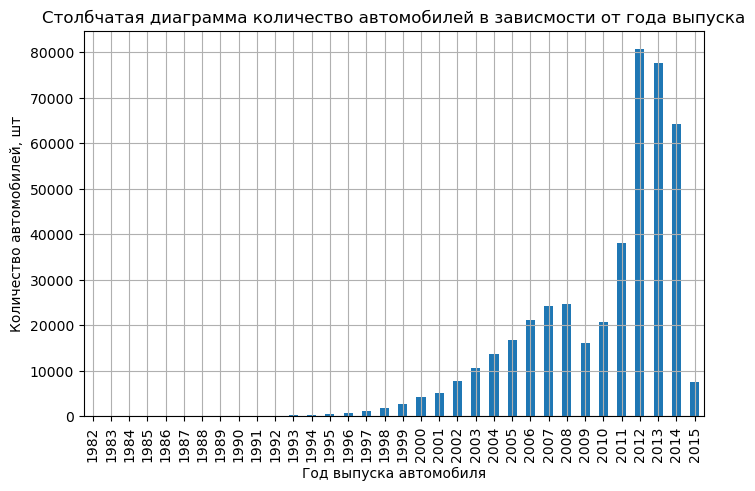

In [104]:
df_train.pivot_table(index = 'year', values='vin', aggfunc='count').plot(kind='bar', y='vin',  legend=False, 
                                                                         figsize=(8,5), grid=True)

plt.title('Столбчатая диаграмма количество автомобилей в зависмости от года выпуска')
plt.xlabel('Год выпуска автомобиля')
plt.ylabel('Количество автомобилей, шт')
plt.show()

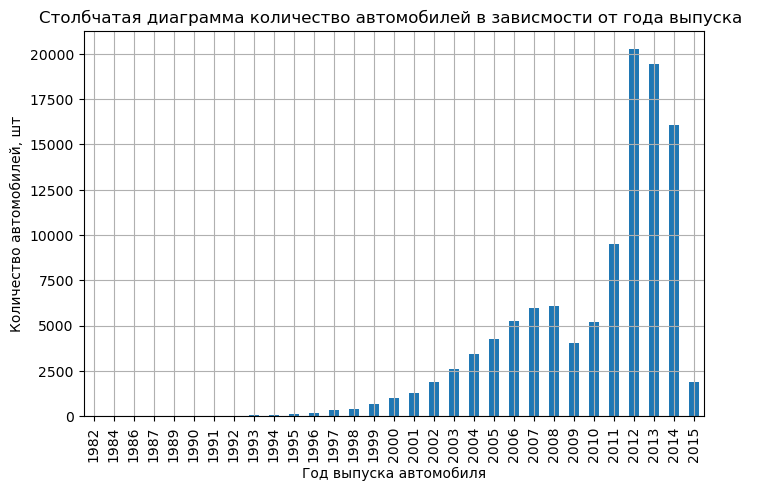

In [105]:
df_test.pivot_table(index = 'year', values='vin', aggfunc='count').plot(kind='bar', y='vin',  legend=False, 
                                                                         figsize=(8,5), grid=True)

plt.title('Столбчатая диаграмма количество автомобилей в зависмости от года выпуска ')
plt.xlabel('Год выпуска автомобиля')
plt.ylabel('Количество автомобилей, шт')
plt.show()

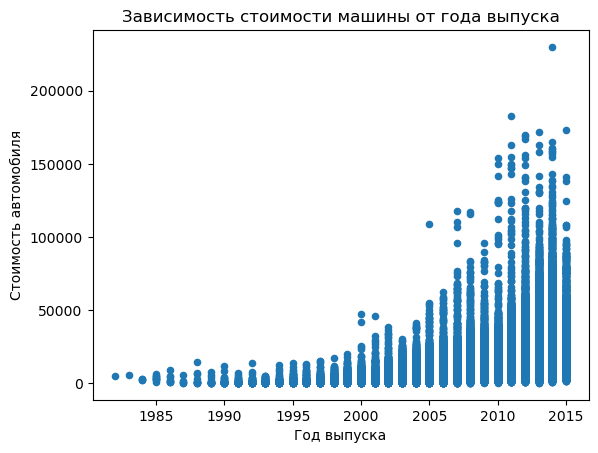

In [106]:
df_train.plot(x='year', y='sellingprice', kind='scatter')


#(df_train.pivot_table(index='year', values='sellingprice', aggfunc='median').
#          reset_index().plot(x='year', y='sellingprice', kind='scatter')
#)

plt.title('Зависимость стоимости машины от года выпуска')
plt.xlabel('Год выпуска')
plt.ylabel('Стоимость автомобиля')
plt.show()

### Распределения данного признака в обоих выборках схожи, наблюдается определенный хвост значений с левой строны, машины старше 2000 года выпуска, которых немного. Но эти данные оставляем, т.к. они есть в обеих выборках и по данным машинам надо предсказать стоимость в тестовой выборке. Коэффиент Пирсона между признаком year и sellingprice df_train составляет 0,59, т.к. зависимость между данным признаком и целевым прослеживается, можно его использовать для обучения моделей. Но мы ввели еще новый признак возраст автомобиля на момент продаджи. Изучим этот признак более детально и возможно будем использовать именно его для обучения модели.


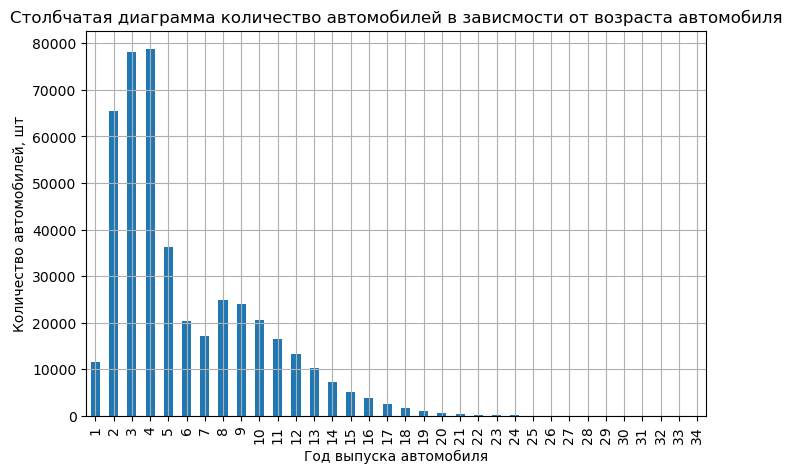

In [107]:
df_train.pivot_table(index = 'car_age', values='vin', aggfunc='count').plot(kind='bar', y='vin',  legend=False, 
                                                                         figsize=(8,5), grid=True)

plt.title('Столбчатая диаграмма количество автомобилей в зависмости от возраста автомобиля')
plt.xlabel('Год выпуска автомобиля')
plt.ylabel('Количество автомобилей, шт')
plt.show()

In [108]:
df_train['car_age'].describe()

count    440234.000000
mean          5.862753
std           3.953851
min           1.000000
25%           3.000000
50%           4.000000
75%           8.000000
max          34.000000
Name: car_age, dtype: float64

In [109]:
p = len(df_train.query('car_age >= 15'))/len(df_train)
print(f'Процентр машин 15 лет и старше: {p :.0%}')

Процентр машин 15 лет и старше: 4%


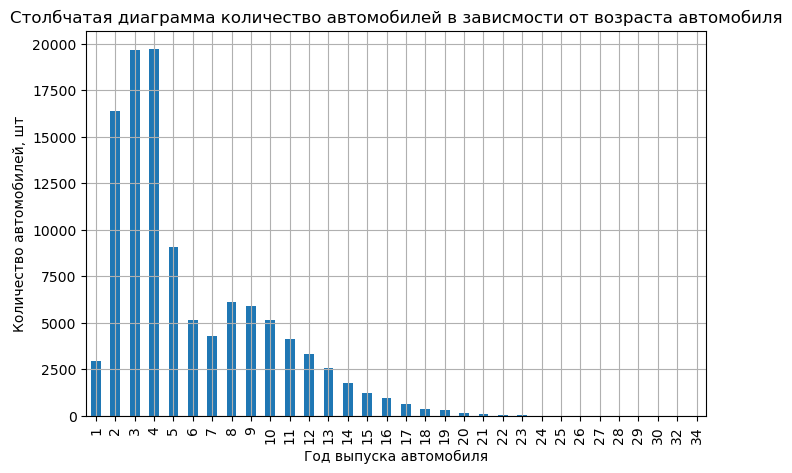

In [110]:
df_test.pivot_table(index = 'car_age', values='vin', aggfunc='count').plot(kind='bar', y='vin',  legend=False, 
                                                                         figsize=(8,5), grid=True)

plt.title('Столбчатая диаграмма количество автомобилей в зависмости от возраста автомобиля')
plt.xlabel('Год выпуска автомобиля')
plt.ylabel('Количество автомобилей, шт')
plt.show()

In [111]:
p_test = len(df_test.query('car_age >= 15'))/len(df_test)
print(f'Процент машин 15 лет и старше: {p_test :.0%}')

Процент машин 15 лет и старше: 4%


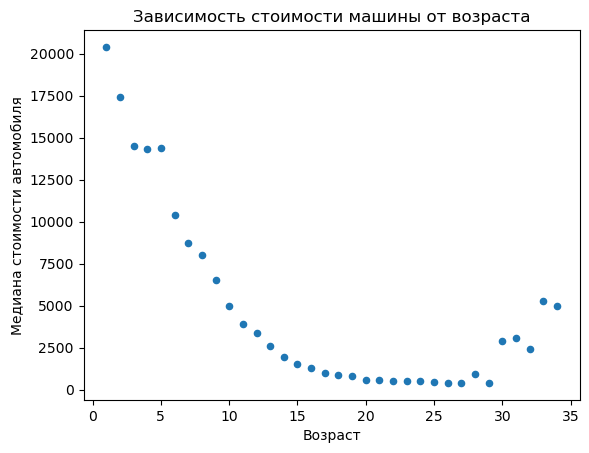

In [112]:
(df_train.pivot_table(index='car_age', values='sellingprice', aggfunc='median').
          reset_index().plot(x='car_age', y='sellingprice', kind='scatter')
)

plt.title('Зависимость стоимости машины от возраста')
plt.xlabel('Возраст')
plt.ylabel('Медиана стоимости автомобиля')
plt.show()

#### Из данных графиков видно, что чаще всего продаются машины в возрасте 3х лет, что может быть связано с окончанием грантийного обслуживания. Машины старше 15 лет составляют около 3 % , но они есть и в тестовой выборке. Поэтому их мо;но оставить, но все объеденить в одну категорию - машины старше 15 лет. Стоимость машин падает с увеличением возраста машины, затем после 27 наблюдается рост стоимости, скорре всего это связано с переходом машин определенного возраста в разряд раритетных. 

#### Напишем функцию для категоризации машин по возрасту, которую применим к обоим датасетам.

In [113]:
def categorize_age (age):
    if age >= 15 and age<=27:
        return '15-27'
    if age > 27:
        return '27+'
    else:
        return "{}".format(age)
    

In [114]:
df_train['age_category'] = df_train['car_age'].apply(categorize_age)
df_train['age_category'].unique()

array(['5', '2', '4', '13', '9', '3', '6', '15-27', '11', '10', '12', '8',
       '7', '1', '14', '27+'], dtype=object)

In [115]:
df_test['age_category'] = df_test['car_age'].apply(categorize_age)
df_test['age_category'].unique()

array(['11', '2', '3', '13', '5', '9', '1', '7', '4', '6', '10', '14',
       '8', '15-27', '12', '27+'], dtype=object)

### Проведем исследование признака make - марка автомобиля. Посторим график распределения количесива машин по маркам. Сделаем сводную таблицу, в которой данные сгрупируем по марке машины и посмотри среднюю и медиагнную стоимость марки.

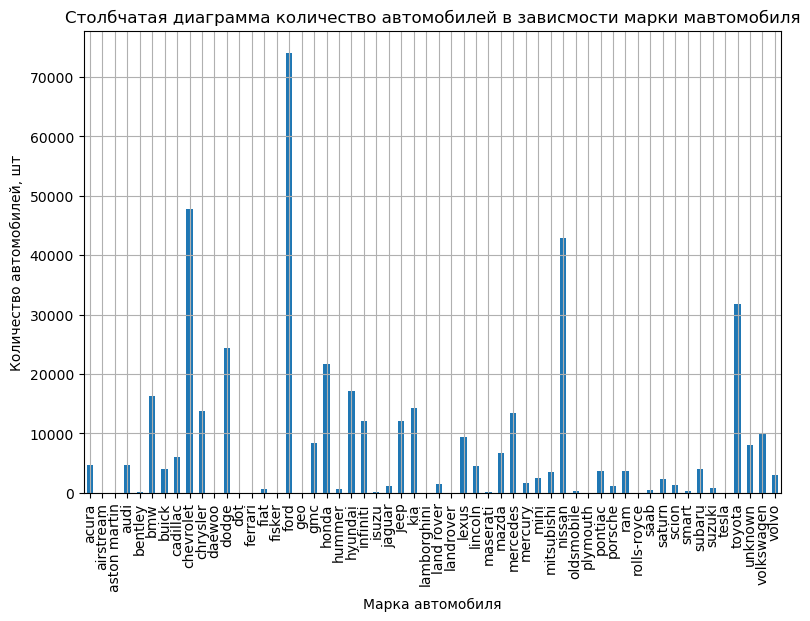

In [116]:
df_train.pivot_table(index = 'make', values='vin', aggfunc='count').plot(kind='bar', y='vin',  legend=False, 
                                                                         figsize=(9,6), grid=True)

plt.title('Столбчатая диаграмма количество автомобилей в зависмости марки мавтомобиля')
plt.xlabel('Марка автомобиля')
plt.ylabel('Количество автомобилей, шт')
plt.show()

In [117]:
df_train.pivot_table(index='make', values='sellingprice', aggfunc='median').sort_values(by='sellingprice', 
                                                                                        ascending=False).head(10)
          

,sellingprice
make,
rolls-royce,152000
ferrari,124000
lamborghini,113000
airstream,71000
tesla,66500
bentley,61500
aston martin,51000
fisker,46500
maserati,44875


#### Лидерами по продажем автомобилей на вторичном рынке являются форд, шеврале, ниссан и тойота. Из полученных данных видно, что цена зависит от марки автомобиля, данный признак нужно использовать для обучения моделей

### Проведем исследование признака model - модель автомобиля. Сделаем сводную таблицу, в которой данные сгрупируем по марке машины, возрасту автомобиля и модели машины и посчитаем медианную стоимость

In [118]:
df_train.pivot_table(index=['make', 'car_age', 'model', ], values='sellingprice', aggfunc='median').sort_values(by='make', 
                                                                                        ascending=False).head(20)
          

sellingprice
make  car_age model              
volvo 23      850           300.0
      7       c70         11000.0
              xc90        11250.0
              xc70        14700.0
              v50         10850.0
              s80          9600.0
              s60          7300.0
              s40          6200.0
              c30          8750.0
      6       c70         13125.0
              xc90        15000.0
              xc70        21000.0
              xc60        15250.0
              v70         11200.0
              v50          9400.0
              s80         11600.0
      8       c30          5750.0
              c70         10850.0
              s40          4800.0
              s60          5700.0

#### Данные подтвердили догадки, что в зависимости от модели стоимость автомобиля меняется, используем данный признак для обучения модели

### Проведем исследование признака trim - модификации автомобиля. Сделаем сводную таблицу, в которой данные сгрупируем по марке машины и модификации автомобиля и посчитаем медианную стоимость

In [119]:
df_train.pivot_table(index=['make', 'trim' ], values='sellingprice', aggfunc='median').sort_values(by='make', 
                                                                                        ascending=False).head(20)

sellingprice
make  trim                             
volvo xc                         1000.0
      level i                     700.0
      hpt                        3700.0
      glts                        350.0
      glt se                     1075.0
      glt                         500.0
      base                       1225.0
      3.2 special edition       10200.0
      3.2 r-design              16400.0
      3.2 premier plus          24000.0
      3.2                       16600.0
      2.9                        1400.0
      2.5t se                    8200.0
      2.5t                       3700.0
      2.4t                       1300.0
      2.4m                        850.0
      2.4i                       3900.0
      ht                         1000.0
      2.4                        1700.0
      lpt                        1400.0

### Проведем исследование признака body - тип кузова. Сделаем сводную таблицу, в которой данные сгрупируем по марке машины и типу кузова автомобиля и посчитаем медианную стоимость

In [120]:
df_train.pivot_table(index=['make', 'body'], values='sellingprice', aggfunc='median').sort_values(by='make', 
                                                                                      ascending=False).head(20)

sellingprice
make       body                            
volvo      wagon                     4050.0
           suv                      12500.0
           sedan                     6700.0
           hatchback                11500.0
           coupe                     1000.0
           convertible              12500.0
volkswagen sedan                     9900.0
           beetle convertible       18050.0
           convertible               5100.0
           hatchback                 8650.0
           minivan                   9600.0
           suv                      13250.0
           unknown                   5250.0
           wagon                     7500.0
unknown    unknown                   5800.0
toyota     hatchback                 9500.0
           access cab               14225.0
           convertible               5500.0
           coupe                     2900.0
           crewmax cab              26600.0

#### Посмотрев на полученные данные мы видим, что цена меняется в зависимости от значения признаком trim и body. Будем использовать данные признаки для обучения модели.

### Проведем исследование признака transmission. Посторим график распределения количесива машин по типу трансмиссии. Сделаем сводную таблицу, в которой данные сгрупируем по марке машины, возрасту автомобиля и типу трансмиссии и посчитаем медианную стоимость

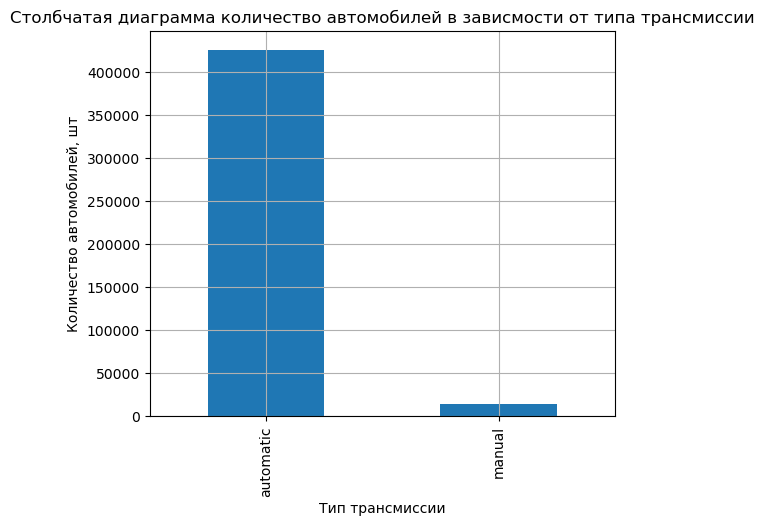

In [121]:
df_train.pivot_table(index = 'transmission', values='vin', aggfunc='count').plot(kind='bar', y='vin',  legend=False, 
                                                                         figsize=(6,5), grid=True)

plt.title('Столбчатая диаграмма количество автомобилей в зависмости от типа трансмиссии')
plt.xlabel('Тип трансмиссии')
plt.ylabel('Количество автомобилей, шт')
plt.show()

In [122]:
df_train.pivot_table(index=['make', 'transmission'], values='sellingprice', aggfunc='median').sort_values(by='make', 
                                                                                      ascending=False).head(20)

sellingprice
make       transmission              
volvo      manual                3500
           automatic             8600
volkswagen manual                5900
           automatic            10000
unknown    manual                7500
           automatic             5700
toyota     manual                4650
           automatic            12200
tesla      automatic            66500
suzuki     manual                3300
           automatic             3100
subaru     automatic            16600
           manual               15000
smart      automatic             5750
scion      manual               10400
           automatic             9000
saturn     manual                1300
           automatic             2900
saab       manual                2250
           automatic             3200

#### Из полученных данных видим, что большинство автомобилей продается с автоматической коробкой передач. Зависимость от типа коробки передач есть, как правило машины с автоматической коробкой передач дороже, но в зависимости от марки автомобиля разница может варьироваться. Оставим данный признак для обучения модели.

### Посмотри прослеживается ли зависимость цены от штата, в которм продавались автомобили.

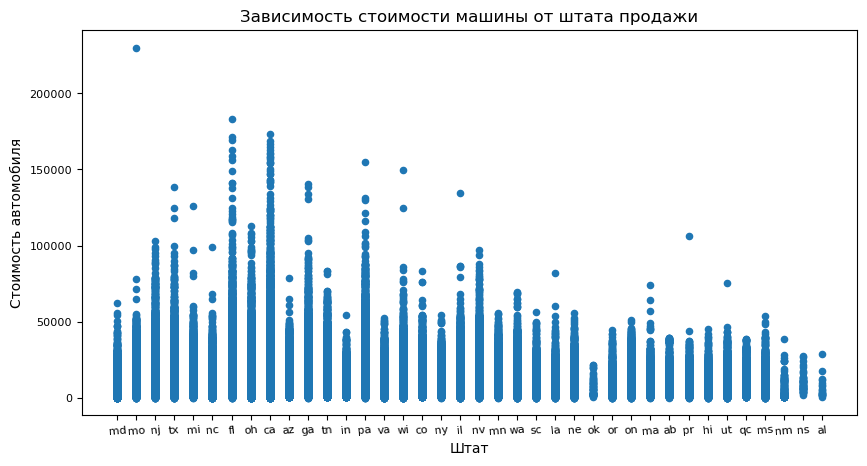

In [123]:
df_train.plot(x='state', y='sellingprice', kind='scatter', rot=5, fontsize=8, figsize=(10,5))
plt.title('Зависимость стоимости машины от штата продажи')
plt.xlabel('Штат')
plt.ylabel('Стоимость автомобиля')
plt.show()

#### Цены в зависимости от штата меняются, но скорре всего это связано с связано с тем, какие марки продаются больше в тех или иных штатах, и вряд ли напрямую влияет на саму стоимость машины.

### Проведем исследование признака condition. А также построим график зависимости состояния автомобиля и цены. Коэффициент Пирсона расчитывали ранее он равен 0,54 для df_train

<AxesSubplot:title={'center':'Состояние автомобиля'}, ylabel='Frequency'>

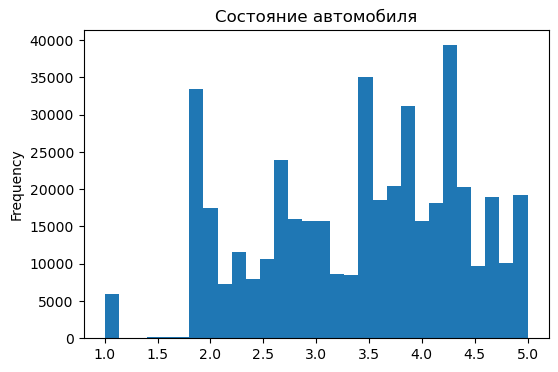

In [124]:
df_train['condition'].plot(kind='hist',  bins=30, title ='Состояние автомобиля', figsize = (6,4))

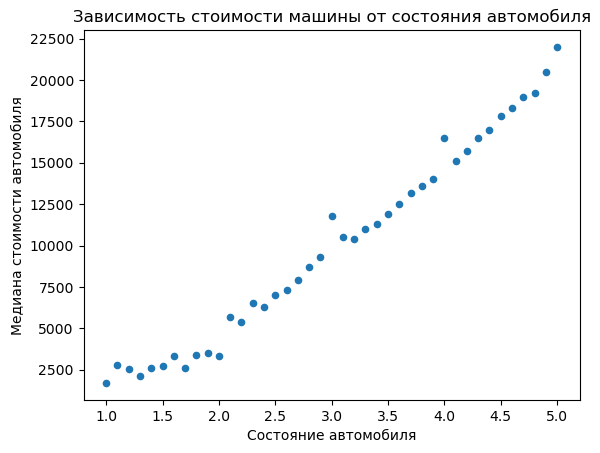

In [125]:
(df_train.pivot_table(index='condition', values='sellingprice', aggfunc='median').
          reset_index().plot(x='condition', y='sellingprice', kind='scatter')
)

plt.title('Зависимость стоимости машины от состояния автомобиля')
plt.xlabel('Состояние автомобиля')
plt.ylabel('Медиана стоимости автомобиля')
plt.show()

#### Из полученных графиков видно, что распределение данного признака не является нормальным и носит скорее искуственный характер. В целом прослеживается зависимость между состоянием автомобиля и ценой, чем лучше состояние автомобиля, тем стоимость выше, но наблюдаются и отдельные выбросы.

### Посчитав ранее кофффициент Пирсона для зависимости цены от пробега (odometer ), мы видим, что зависимочть есть, чем выше пробег, тем ниже цена, но пробег также сильно креллируется с годом выпуска автомобиля. Поэтому попробуем посчитать среднегодовой пробег, который говорит о том, как автомобиль эксплуатировался и ввести соответсвующие категории от 0 до 10000 - small, от 10000 до 20 000 - mean, свыше 20 000 - large. Также в данном столбце были аномалии по пробегу, попробуем их убрать, заменив аномальные значения на медианну. Это делаем для обоих датасетов.

#### Для расчета среднего пробега в год, делим пробег на возраст автомобиля, с учетом того, что на 0 делить нельзя.

In [126]:
try:
    df_train['average_year_run'] = df_train['odometer']/df_train['car_age']
except:
     print('Ошибка')

In [127]:
median_run = df_train['average_year_run'].median()
median_run

11049.619047619048

In [128]:
df_train.query('average_year_run > 2000 and car_age >=2')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,...,interior,seller,sellingprice,saledate,saledate_year,saledate_month,saledate_week_day,car_age,age_category,average_year_run
0,2011,ford,edge,sel,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,...,black,santander consumer,12500,2015-06-01 19:30:00+00:00,2015,6,0,5,5,22208.200000
1,2014,ford,fusion,se,sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,...,black,ars/avis budget group,14500,2015-02-24 18:00:00+00:00,2015,2,1,2,2,15517.000000
2,2012,nissan,sentra,2.0 sl,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,...,black,nissan-infiniti lt,9100,2015-06-09 19:30:00+00:00,2015,6,1,4,4,8904.750000
3,2003,hummer,h2,base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,...,beige,wichita falls ford lin inc,13300,2015-06-16 20:00:00+00:00,2015,6,1,13,13,10100.076923
4,2007,ford,fusion,sel,sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,...,black,purple heart,1300,2015-02-02 20:00:00+00:00,2015,2,0,9,9,14189.888889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440231,2013,kia,optima,ex hybrid,sedan,automatic,knagm4ad4d5057805,ca,4.5,20434.0,...,beige,"kia motors america, inc",16000,2015-01-19 20:30:00+00:00,2015,1,0,3,3,6811.333333
440232,2014,mini,cooper countryman,s all4,wagon,automatic,wmwzc5c55ewp36517,wi,2.9,14675.0,...,black,bmw mini financial services,24250,2015-02-10 18:00:00+00:00,2015,2,1,2,2,7337.500000
440233,2008,bmw,6 series,650i,coupe,automatic,wbaea53588cv90110,ca,3.7,102552.0,...,black,studio city auto group,16750,2015-03-02 20:30:00+00:00,2015,3,0,8,8,12819.000000
440234,2014,ram,2500,slt,crew cab,automatic,3c6ur5dl2eg243568,tx,3.0,29367.0,...,gray,express car & truck rental,33000,2015-01-13 18:05:00+00:00,2015,1,1,2,2,14683.500000


#### Заменим в данных строках значение average_year_run на медианное median_run

In [129]:
df_train.loc[(df_train['average_year_run'] < 2000) & (df_train['car_age'] >= 2), 'average_year_run'] = median_run
df_train['average_year_run'] = df_train['average_year_run']

In [130]:
df_train.loc[125]

year                                      2000
make                                      jeep
model                                 cherokee
trim                                     sport
body                                       suv
transmission                         automatic
vin                          1j4ff48s5yl232779
state                                       ny
condition                                  3.1
odometer                                   1.0
color                                     blue
interior                                  gray
seller                 morehead auto sales inc
sellingprice                               300
saledate             2015-01-20 17:00:00+00:00
saledate_year                             2015
saledate_month                               1
saledate_week_day                            1
car_age                                     16
age_category                             15-27
average_year_run                  11049.619048
Name: 125, dt

#### Напишем функцию для категоризации машин по среднегодовому пробегу 

In [131]:
def categorize_run (average_year_run):
    if average_year_run < 7000:
        return 'small'
    if average_year_run >= 7000 and average_year_run<= 20000:
        return 'mean'
    else:
        return 'large'

In [132]:
df_train['average_year_run_category'] = df_train['average_year_run'].apply(categorize_run)
df_train['average_year_run_category'].unique()

array(['large', 'mean', 'small'], dtype=object)

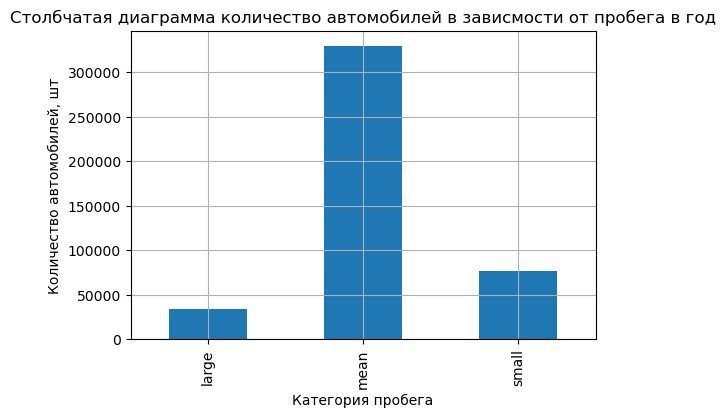

In [133]:
df_train.pivot_table(index = 'average_year_run_category', values='vin', aggfunc='count').plot(kind='bar', y='vin',  legend=False, 
                                                                         figsize=(6,4), grid=True)

plt.title('Столбчатая диаграмма количество автомобилей в зависмости от пробега в год')
plt.xlabel('Категория пробега')
plt.ylabel('Количество автомобилей, шт')
plt.show()

#### Аналогично поступаем с df_test

In [134]:
try:
    df_test['average_year_run'] = df_test['odometer']/df_test['car_age']
except:
    print('Ошибка')
  

In [135]:
median_run_test = df_test['average_year_run'].median()
median_run_test

11034.325

In [136]:
df_test.loc[(df_test['average_year_run'] < 2000) & (df_test['car_age'] >= 2), 'average_year_run'] = median_run_test

In [137]:
df_test['average_year_run_category'] = df_test['average_year_run'].apply(categorize_run)
df_test['average_year_run_category'].unique()

array(['mean', 'small', 'large'], dtype=object)

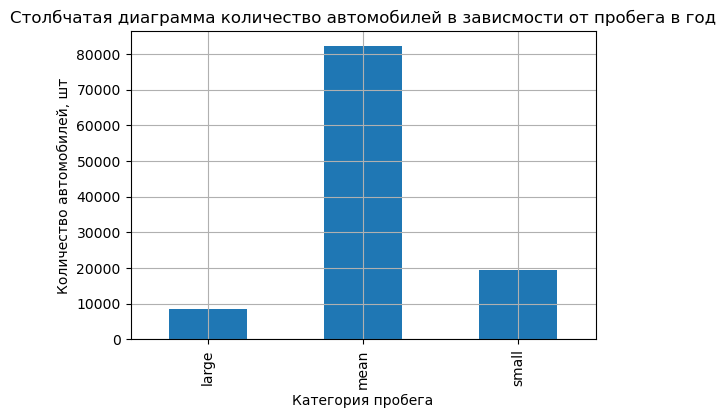

In [138]:
df_test.pivot_table(index = 'average_year_run_category', values='vin', aggfunc='count').plot(kind='bar', y='vin',  legend=False, 
                                                                         figsize=(6,4), grid=True)

plt.title('Столбчатая диаграмма количество автомобилей в зависмости от пробега в год')
plt.xlabel('Категория пробега')
plt.ylabel('Количество автомобилей, шт')
plt.show()

In [139]:
df_test.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,...,interior,seller,saledate,saledate_year,saledate_month,saledate_week_day,car_age,age_category,average_year_run,average_year_run_category
0,2005,cadillac,cts,base,sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,...,black,lexus of stevens creek,2015-01-13 20:30:00+00:00,2015,1,1,11,11,10633.636364,mean
1,2014,gmc,savana cargo,2500,van,automatic,1gtw7fca7e1902207,pa,4.4,6286.0,...,gray,u-haul,2015-02-26 17:00:00+00:00,2015,2,3,2,2,3143.000000,small
2,2013,nissan,murano,s,suv,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,...,black,nissan-infiniti lt,2015-02-23 17:30:00+00:00,2015,2,0,3,3,3943.666667,small
3,2013,chevrolet,impala,ls fleet,sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,...,black,onemain rem/auto club of miami inc dba north dad,2015-03-05 18:00:00+00:00,2015,3,3,3,3,19035.000000,mean
4,2013,nissan,titan,sv,crew cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,...,black,nissan north america inc.,2015-06-02 20:30:00+00:00,2015,6,1,3,3,10361.000000,mean


### Рассмотрим признак color - цвет автомобиля. Построим столбчатую диаграмму колличества автомобилей в зависимости от цвета машины. Сделаем сводную таблицу, сгруппированную по марке, модели и возрасту и цвету автомобиля, чтобы посмотреть отличается средняя цена автомобиля одного, производителя, модели , года выпуска в зависимости от цвета.

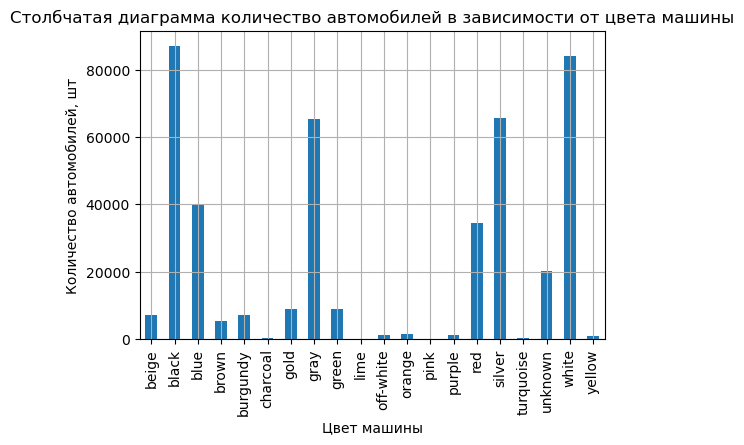

In [140]:
df_train.pivot_table(index = 'color', values='vin', aggfunc='count').plot(kind='bar', y='vin',  legend=False, 
                                                                         figsize=(6,4), grid=True)

plt.title('Столбчатая диаграмма количество автомобилей в зависимости от цвета машины')
plt.xlabel('Цвет машины')
plt.ylabel('Количество автомобилей, шт')
plt.show()

In [141]:
df_train.pivot_table(index=['make','model', 'car_age', 'color' ], values='sellingprice', aggfunc='median').sort_values(by='make', 
                                                                                        ascending=False).head(20)

sellingprice
make  model car_age color                
volvo xc90  13      white          1300.0
      s60   12      black          2200.0
            11      white          2850.0
                    unknown        5200.0
                    silver         4200.0
                    red            2500.0
                    gray           3500.0
                    blue           2600.0
                    black          2925.0
                    beige          1800.0
            10      white          3800.0
                    silver         3500.0
                    green          5150.0
                    gray           3900.0
                    blue           3550.0
                    black          4100.0
            9       white          5650.0
                    silver         4700.0
                    red            3300.0
                    green          5000.0

#### Из полученных данных видно, что наибольшее количество продаваемых машин черного, белого, серого и серебристого, голубого и красного цветов. Остальные машины встречаются редко. Определенные колебания в цене в зависимости от цвета есть, но, я думаю, это скорее обусловлено и сочетанием других факторов, например, состоянием автомобиля.

### Рассмотрим признак interior - цвет салона. Построим столбчатую диаграмму колличества автомобилей в зависимости от цвета салона. Сделаем сводную таблицу, сгруппированную по марке, модели и возрасту и цвету салона, чтобы посмотреть отличается средняя цена автомобиля одного, производителя, модели , года выпуска в зависимости от цвета

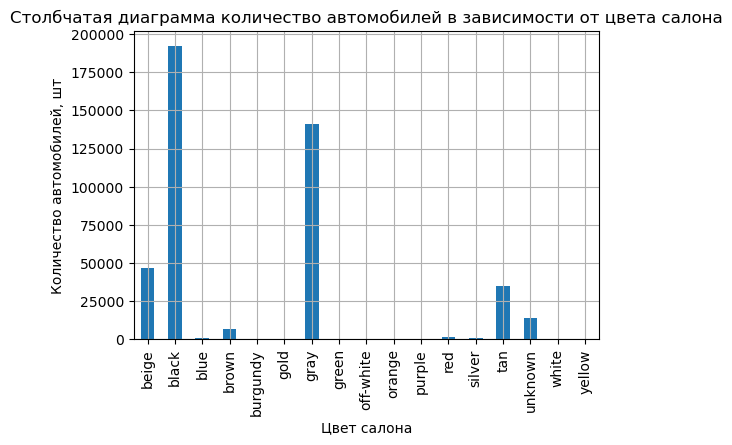

In [142]:
df_train.pivot_table(index = 'interior', values='vin', aggfunc='count').plot(kind='bar', y='vin',  legend=False, 
                                                                         figsize=(6,4), grid=True)

plt.title('Столбчатая диаграмма количество автомобилей в зависимости от цвета салона')
plt.xlabel('Цвет салона')
plt.ylabel('Количество автомобилей, шт')
plt.show()

In [143]:
df_train.pivot_table(index=['make','model', 'car_age', 'interior' ], values='sellingprice', aggfunc='median').sort_values(by='make', 
                                                                                        ascending=False).head(20)

sellingprice
make  model car_age interior              
volvo xc90  13      tan             1600.0
      s60   9       tan             5000.0
            5       unknown        15250.0
            7       beige           5600.0
                    black           7450.0
                    gray            8550.0
                    silver          3500.0
            8       beige           6700.0
                    black           6000.0
                    gray            4850.0
                    tan             4700.0
                    unknown         2850.0
            9       beige           3850.0
                    black           4200.0
                    gray            3900.0
                    unknown         5500.0
            5       brown          12200.0
            10      beige           4100.0
                    black           3500.0
                    gray            3600.0

#### Из полученных данных видно, что наибольшее количество продаваемых машин, у которых салон черного, серонго, бежевого и желто-коричневого цвета. Остальные машины встречаются редко. Определенные колебания в цене в зависимости от цвета есть, но какоц-то четкой зависимости не вижно, я думаю, это скорее обусловлено и сочетанием других факторов, например, состоянием автомобиля.

### Рассмотрим признак seller - продавец. Построим сколько уникальных значений в данном признаке.

In [144]:
len(df_train['seller'].unique())

13025

#### В данном признаке очень много уникальных значений. Не будем использовать его для обучения модели.

### Зависимость цены от года продажи автомобиля не будем, т.к. у нас нет для этого достаточных статистических данных (практически все машины продавались в 2015 году). Данный признак не будем использовать и для обучения. Но попробуем посмотреть зависимость стоиммости от месяца и дня недели продажи. посчитаем коэффициент корреляции Пирсона и построим графики распределения по количеству машин в месяц продажи и день недели, а также графики зависимости цены от мсяца и дня продажи.

Коэффициент корреляции: -0.031179702261062543


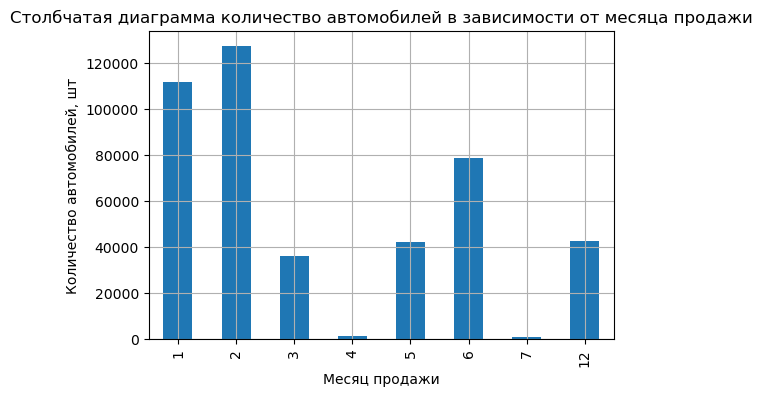

In [145]:
print('Коэффициент корреляции:', df_train['saledate_month'].corr(df_train['sellingprice']))
df_train.pivot_table(index = 'saledate_month', values='vin', aggfunc='count').plot(kind='bar', y='vin',  legend=False, 
                                                                         figsize=(6,4), grid=True)

plt.title('Столбчатая диаграмма количество автомобилей в зависимости от месяца продажи')
plt.xlabel('Месяц продажи')
plt.ylabel('Количество автомобилей, шт')
plt.show()

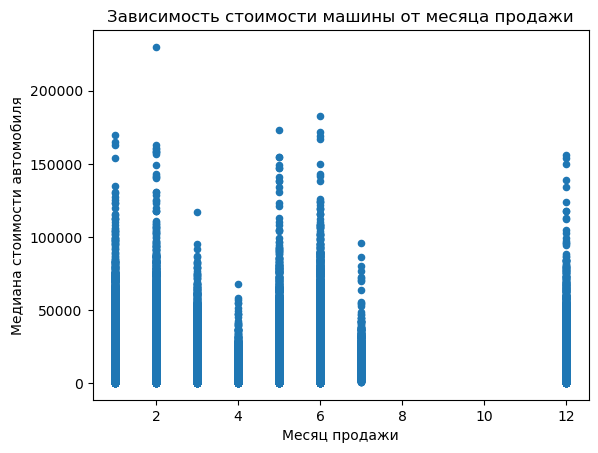

In [146]:
df_train.plot(x='saledate_month', y='sellingprice', kind='scatter')


plt.title('Зависимость стоимости машины от месяца продажи')
plt.xlabel('Месяц продажи')
plt.ylabel('Медиана стоимости автомобиля')
plt.show()

Коэффициент корреляции: -0.001741146110299509


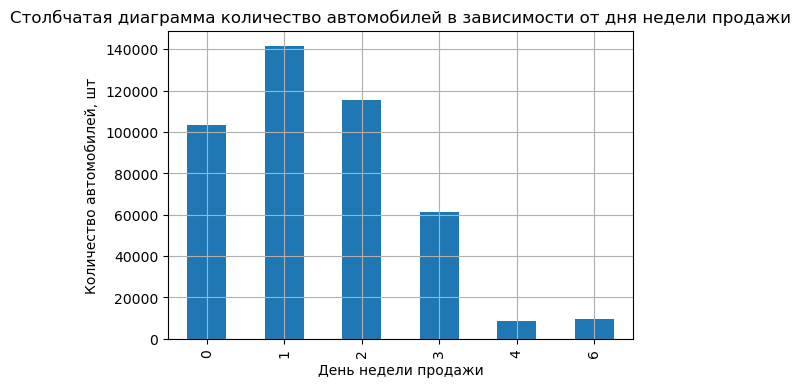

In [147]:
print('Коэффициент корреляции:', df_train['saledate_week_day'].corr(df_train['sellingprice']))
df_train.pivot_table(index = 'saledate_week_day', values='vin', aggfunc='count').plot(kind='bar', y='vin',  legend=False, 
                                                                         figsize=(6,4), grid=True)

plt.title('Столбчатая диаграмма количество автомобилей в зависимости от дня недели продажи')
plt.xlabel('День недели продажи')
plt.ylabel('Количество автомобилей, шт')
plt.show()

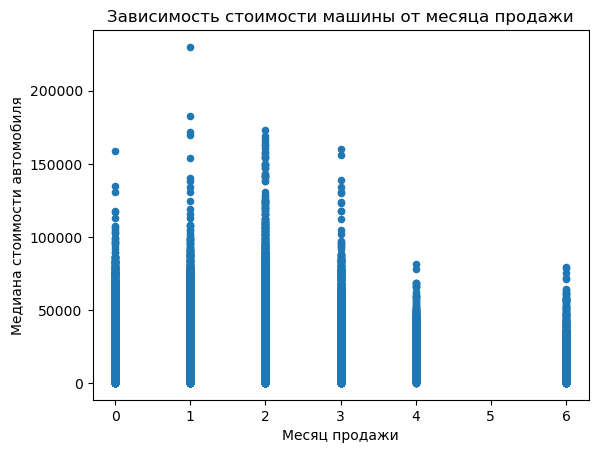

In [148]:
df_train.plot(x='saledate_week_day', y='sellingprice', kind='scatter')


plt.title('Зависимость стоимости машины от месяца продажи')
plt.xlabel('Месяц продажи')
plt.ylabel('Медиана стоимости автомобиля')
plt.show()

#### Из полученных данных видно, что наибольшее количество машин продается в феврале и январе, а также во понедельник. Из коэффициента корреляции, мы видим, что нет линейной зависимости, но возможно эта зависимость просто другая или действует сочетание нескольких факторов, т.к. коллебания стоимость все-таки есть. Какой-то четко выраженной сезонности не наблюдается.  

### Проверим, что получилив результате исселедовательского анализа данных. Методом info() получим общую информацию о датасетах.

In [149]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440234 entries, 0 to 440235
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   year                       440234 non-null  int64              
 1   make                       440234 non-null  object             
 2   model                      440234 non-null  object             
 3   trim                       440234 non-null  object             
 4   body                       440234 non-null  object             
 5   transmission               440234 non-null  object             
 6   vin                        440234 non-null  object             
 7   state                      440234 non-null  object             
 8   condition                  440234 non-null  float64            
 9   odometer                   440234 non-null  float64            
 10  color                      440234 non-null  object      

In [150]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   year                       110058 non-null  int64              
 1   make                       110058 non-null  object             
 2   model                      110058 non-null  object             
 3   trim                       110058 non-null  object             
 4   body                       110058 non-null  object             
 5   transmission               110058 non-null  object             
 6   vin                        110058 non-null  object             
 7   state                      110058 non-null  object             
 8   condition                  110058 non-null  float64            
 9   odometer                   110058 non-null  float64            
 10  color                      110058 non-null  object      

### На данном шаге, мы провели исследование распределения признаков, изучили возможные зависимости стоимости автомобиля от признаков, удалили ряд анамальных данных, добавили столбцы car_age, age_category, average_year_run, average_year_run_category

## Шаг 4. Отбор финального набора обучающих признаков

### Целевым признаком в нашей задаче регрессии по определению стоимости машины на вторичном рынке целевым показателем является sellingprice. Разобьем обучающую и тестовую выборку на признаки и целевой признак, удалив из признаков все несущественны признаки (year, vin, state, odometer, seller, saledate, saledate_year, car_age, average_year_run)

In [151]:
target = df_train['sellingprice']
target.shape

(440234,)

In [152]:
df_train['average_year_run'] = df_train['average_year_run'].astype('int64')

In [153]:
features = df_train.drop([ 'year', 'vin', 'state', 'odometer', 'seller','saledate', 'saledate_year', 'sellingprice'], axis=1)
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440234 entries, 0 to 440235
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   make                       440234 non-null  object 
 1   model                      440234 non-null  object 
 2   trim                       440234 non-null  object 
 3   body                       440234 non-null  object 
 4   transmission               440234 non-null  object 
 5   condition                  440234 non-null  float64
 6   color                      440234 non-null  object 
 7   interior                   440234 non-null  object 
 8   saledate_month             440234 non-null  int64  
 9   saledate_week_day          440234 non-null  int64  
 10  car_age                    440234 non-null  int64  
 11  age_category               440234 non-null  object 
 12  average_year_run           440234 non-null  int64  
 13  average_year_run_category  44

#### Разобъем обучающую выборку на обучающую и валидациооную на train и valid, чтобы оценитть метрику прежде чем проводить окончательное тестирвоание выбранной модеди на test.

In [154]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, 
                                                                              random_state=RANDOM_STATE)
print(features_train.shape)
print(features_valid.shape)
print(target_train.shape)
target_valid.shape

(330175, 14)
(110059, 14)
(330175,)


(110059,)

In [155]:
df_test['average_year_run'] = df_test['average_year_run'].astype('int64')

In [156]:
features_test = df_test.drop([ 'year', 'vin', 'state', 'odometer', 'seller','saledate', 'saledate_year'], axis=1)
features_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   make                       110058 non-null  object 
 1   model                      110058 non-null  object 
 2   trim                       110058 non-null  object 
 3   body                       110058 non-null  object 
 4   transmission               110058 non-null  object 
 5   condition                  110058 non-null  float64
 6   color                      110058 non-null  object 
 7   interior                   110058 non-null  object 
 8   saledate_month             110058 non-null  int64  
 9   saledate_week_day          110058 non-null  int64  
 10  car_age                    110058 non-null  int64  
 11  age_category               110058 non-null  object 
 12  average_year_run           110058 non-null  int64  
 13  average_year_run_category  11

#### Определим категориальные и количественные признаки

In [157]:
cat_columns = features_train.select_dtypes(include='object').columns
num_columns = features_train.select_dtypes(include='number').columns
print(cat_columns)
num_columns

Index(['make', 'model', 'trim', 'body', 'transmission', 'color', 'interior',
       'age_category', 'average_year_run_category'],
      dtype='object')


Index(['condition', 'saledate_month', 'saledate_week_day', 'car_age',
       'average_year_run'],
      dtype='object')

#### На данном шаге было сделано следуюшее:
- разделили обучающую выборку на train и valid в пропорции 75 - 25
- определились с набором обучающих признаков
- выделили в датасетах целевой признак и признаки
- разбили признаки на категориальные и количественные

## Шаг 4: Обучаем модели.

### Исследуем модель случайный лес. Создадим Column_transformer для модели случайный лес, затем pipline и с помощью RandomizedSearchCV будем подбирать гиперпараметры. Используемая метрика для оценки - MAPE

In [158]:
column_transformer_rforest = make_column_transformer((StandardScaler(),num_columns), 
                                                     (OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
                                                      , cat_columns),
                                                     remainder = 'passthrough')
model = RandomForestRegressor (random_state=RANDOM_STATE)
pipline_rf = make_pipeline(column_transformer_rforest, model)
pipline_rf

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  Index(['condition', 'saledate_month', 'saledate_week_day', 'car_age',
       'average_year_run'],
      dtype='object')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['make', 'model', 'trim', 'body', 'transmission', 'color', 'interior',
       'age_category', 'average_year_run_category'],
      dtype='object'))])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=12345))])

In [159]:
# param_rf = {
#     'randomforestregressor__n_estimators': range(10, 60, 10),
#     'randomforestregressor__max_depth': range(1, 10),
#     'randomforestregressor__min_samples_split': (2, 3, 4),
#     'randomforestregressor__min_samples_leaf': (1, 2, 3, 4)
# }

# grid_rf = RandomizedSearchCV(
#     pipline_rf, 
#     param_rf, 
#     n_iter=10,
#     cv=5,
#     verbose=5,
#     scoring='neg_mean_absolute_percentage_error', 
#     n_jobs=-1, 
#     random_state=RANDOM_STATE
# )
# grid_rf

In [160]:
# %%time
# grid_rf.fit(features_train, target_train)

In [161]:
#grid_rf.best_score_

In [162]:
#grid_rf.best_params_

In [163]:
#predicted = grid_rf.predict(features_valid)
#mean_absolute_percentage_error(target_valid, predicted).round(2)

In [164]:
#cv_scores = cross_val_score(grid_rf,  features_train, target_train, cv=5,  scoring='neg_mean_absolute_percentage_error')
#cv_scores

In [165]:
# print(f'Mean MAPE = {cv_scores.mean():.2f}')
# print(f'Mean STD = +-{cv_scores.std():.3f}')

In [166]:
# model_bp = RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=50, min_samples_split=2, min_samples_leaf=4,
#                                  max_depth=8)
# pipline_rf_bp = make_pipeline(column_transformer_rforest, model_bp)
# pipline_rf_bp.fit(features_train, target_train)

In [167]:
# feature_importance = pipline_rf_bp.named_steps['randomforestregressor'].feature_importances_
# feature_names = column_transformer_rforest.get_feature_names_out()
# feature_names

In [168]:
#fi= pd.Series(feature_importance, index=feature_names).sort_values().plot(kind='barh')

### Исследуем модель Catboostregressor. C помощью RandomizedSearchCV будем подбирать гиперпараметры. Используемая метрика для оценки - MAPE

In [169]:
model = CatBoostRegressor(random_seed=RANDOM_STATE,
                          silent=True,
                          cat_features=[0,1,2,3,4,6,7,11,13])

In [170]:
params = {
    'learning_rate':[0.01, 0.1, 0.3],
    'iterations': [40, 60],
    'depth': [d for d in range(2, 11)],
}

grid_cbr = RandomizedSearchCV(model,
                         params,
                         n_iter=10,
                         cv=5,
                         scoring='neg_mean_squared_error',
                         verbose=False)

In [171]:
%%time
grid_cbr.fit(features_train,target_train)

Wall time: 4min 14s


RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostRegressor object at 0x0000025900F95F40>,
                   param_distributions={'depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                                        'iterations': [40, 60],
                                        'learning_rate': [0.01, 0.1, 0.3]},
                   scoring='neg_mean_squared_error', verbose=False)

In [172]:
grid_cbr.best_params_

{'learning_rate': 0.3, 'iterations': 40, 'depth': 10}

In [173]:
predicted = grid_cbr.predict(features_valid)
mean_absolute_percentage_error(target_valid, predicted).round(2)

0.22

In [174]:
#cv_scores_cat = cross_val_score(grid_cbr,  features_train, target_train, cv=5,  scoring='neg_mean_absolute_percentage_error')
#cv_scores_cat

#### Не смогла посчитать, т.к. зависает.

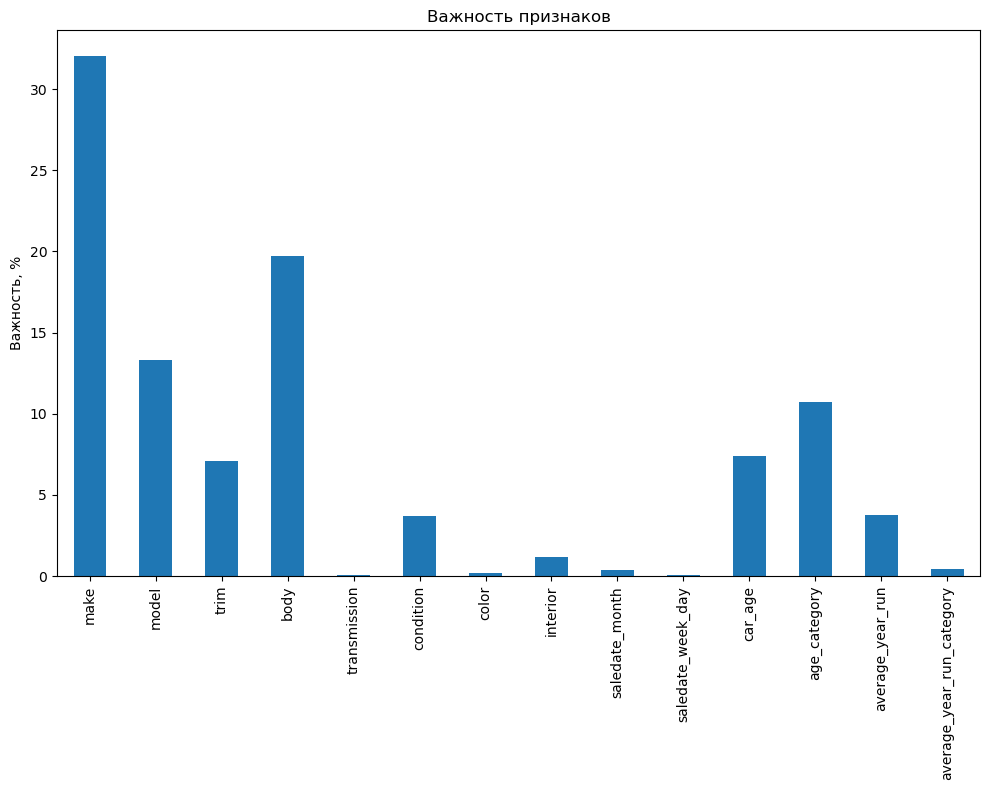

In [175]:
model_1 = CatBoostRegressor(random_seed=RANDOM_STATE, silent=True, cat_features=[0,1,2,3,4,6,7,11,13], 
                          learning_rate=0.3, iterations=60, depth=10)
model_1.fit(features_train,target_train)
features_importance = pd.Series(model_1.get_feature_importance(),
                         (features_train).columns)
fig, ax = plt.subplots(figsize=(10, 8))
features_importance.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

#### Из графика видно, что наиболее значимые признаки make, body, model,  age_category, car_age, trim, condition,  average_year_run. Так как значение метрики достотоно близко к требуемому, сделаем предсказания на тестовой выборке.

In [176]:
predicted_test = grid_cbr.predict(features_test)
predicted_test

array([ 5028.13557441, 22161.95238101, 22532.7028253 , ...,
        3863.3386312 , 18984.34168308, 18409.84411472])

#### Добавим в столбец с предсказаниями в df_test

In [177]:
df_test['sellingprice_pr'] = predicted_test
df_test.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,...,seller,saledate,saledate_year,saledate_month,saledate_week_day,car_age,age_category,average_year_run,average_year_run_category,sellingprice_pr
0,2005,cadillac,cts,base,sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,...,lexus of stevens creek,2015-01-13 20:30:00+00:00,2015,1,1,11,11,10633,mean,5028.135574
1,2014,gmc,savana cargo,2500,van,automatic,1gtw7fca7e1902207,pa,4.4,6286.0,...,u-haul,2015-02-26 17:00:00+00:00,2015,2,3,2,2,3143,small,22161.952381
2,2013,nissan,murano,s,suv,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,...,nissan-infiniti lt,2015-02-23 17:30:00+00:00,2015,2,0,3,3,3943,small,22532.702825
3,2013,chevrolet,impala,ls fleet,sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,...,onemain rem/auto club of miami inc dba north dad,2015-03-05 18:00:00+00:00,2015,3,3,3,3,19035,mean,8447.659518
4,2013,nissan,titan,sv,crew cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,...,nissan north america inc.,2015-06-02 20:30:00+00:00,2015,6,1,3,3,10361,mean,24132.755646


#### Добавим столбец с педсказаниями в датафрейм, объеденив таблицы по vin merge(). 

In [178]:
submission = submission.merge(df_test, on='vin', how='left')
submission.head()

,vin,sellingprice,year,make,model,trim,body,transmission,state,condition,...,seller,saledate,saledate_year,saledate_month,saledate_week_day,car_age,age_category,average_year_run,average_year_run_category,sellingprice_pr
0,1g6dp567450124779,13592.209588,2005,cadillac,cts,base,sedan,automatic,ca,2.7,...,lexus of stevens creek,2015-01-13 20:30:00+00:00,2015,1,1,11,11,10633,mean,5028.135574
1,1gtw7fca7e1902207,13592.209588,2014,gmc,savana cargo,2500,van,automatic,pa,4.4,...,u-haul,2015-02-26 17:00:00+00:00,2015,2,3,2,2,3143,small,22161.952381
2,jn8az1mw6dw303497,13592.209588,2013,nissan,murano,s,suv,automatic,oh,4.6,...,nissan-infiniti lt,2015-02-23 17:30:00+00:00,2015,2,0,3,3,3943,small,22532.702825
3,2g1wf5e34d1160703,13592.209588,2013,chevrolet,impala,ls fleet,sedan,automatic,fl,2.3,...,onemain rem/auto club of miami inc dba north dad,2015-03-05 18:00:00+00:00,2015,3,3,3,3,19035,mean,8447.659518
4,1n6aa0ec3dn301209,13592.209588,2013,nissan,titan,sv,crew cab,automatic,tn,2.9,...,nissan north america inc.,2015-06-02 20:30:00+00:00,2015,6,1,3,3,10361,mean,24132.755646


In [180]:
column = submission.columns
print(column)
submission = submission[['vin', 'sellingprice_pr']]
display(submission.head())
submission.isna().sum()

Index(['vin', 'sellingprice', 'year', 'make', 'model', 'trim', 'body',
       'transmission', 'state', 'condition', 'odometer', 'color', 'interior',
       'seller', 'saledate', 'saledate_year', 'saledate_month',
       'saledate_week_day', 'car_age', 'age_category', 'average_year_run',
       'average_year_run_category', 'sellingprice_pr'],
      dtype='object')


,vin,sellingprice_pr
0,1g6dp567450124779,5028.135574
1,1gtw7fca7e1902207,22161.952381
2,jn8az1mw6dw303497,22532.702825
3,2g1wf5e34d1160703,8447.659518
4,1n6aa0ec3dn301209,24132.755646


vin                0
sellingprice_pr    0
dtype: int64

In [181]:
submission.columns = ['vin', 'sellingprice']
submission.head()

,vin,sellingprice
0,1g6dp567450124779,5028.135574
1,1gtw7fca7e1902207,22161.952381
2,jn8az1mw6dw303497,22532.702825
3,2g1wf5e34d1160703,8447.659518
4,1n6aa0ec3dn301209,24132.755646


In [182]:
submission.to_csv('tmp.csv')

#### Итоговый вывод: В результате разработки модели для предсказания стоимости автомобилей на вторичном рынке было сделано следующее:
1. Изучив данные:
Изменили тип данных в столбце saledate в датафреймах df_train и df_test на datetime, оставив локальное время покупки, добавили столбцы с годом, месяцем и днем недели продажи автомобиля.
Исключили неявные дубликаты в столбцах make, model, trim, body, заменили в них пропуски на unknown (где инфоромации нет) и данные (где удалось восстановить информацию).
В столбцах transmission color interior пропуски заменили на unknown. В столбцах color interior "-" также заменили на unknown.
добавили столбец car_age с возрастом автомобиля на момент продажи
В столлбцах condition odometer пропуски замели медианным значением в группах в зависимости от возраста автомобиля на момент продажи.
Убедились, что нет дубликатов в столбцах vin df_train и df_test, т.к. данные значения должны быть уникальными.
2.Провели исследование распределения признаков, изучили возможные зависимости стоимости автомобиля от признаков, удалили ряд анамальных данных, добавили столбцы car_age, age_category, average_year_run, average_year_run_category
3. На этапе отбора признаков для обучения:
- разделили обучающую выборку на train и valid в пропорции 75 - 25 (для оценки качества модели на валидационной выборке)
- определились с набором обучающих признаков ( make  model object  trim  body transmission  condition color interior saledate_month saledate_week_day car_age age_category average_year_run average_year_run_category
- выделили в датасетах целевой признак и признаки
- разбили признаки на категориальные и количественные
4. Изучили две модели случайный лес RandomForestRegressor и Catboostregressor. В обоих случая использовала RandomizedSearchCV для подбора гиперпараметров. Для оценки качества использовали метрику - MAPE.
Лучшие результаты показала модель Catboostregressoк, MAPE = 0.21, поэтому дл предсказания стоимости автомоблиля в тестовой выборке использовали данную модель. Анализ важности признаков показал, что наиболее значимыми являются - make, body, model, age_category, car_age, trim, condition, average_year_run.